In [133]:
! pip install sqlalchemy
! pip install shap

# Импорты и константы

In [134]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import requests
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
     f1_score,
     confusion_matrix,
     roc_auc_score,
     roc_curve
)
from scipy import stats as st
import missingno

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import *

from time import time

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score
)
import shap
import optuna

RANDOM_STATE = 1220

# Первичное исследование таблиц

In [3]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    for i in df.select_dtypes(include='object').columns.to_list():
        print('--------------------------------------')
        print(f'| Уникальные значения признака {i} |')
        print('--------------------------------------')
        print(df[i].unique())


def view_distribution(data):
    interval_cols = data.select_dtypes(include='object').columns.to_list()
    fig, axes = plt.subplots(nrows=len(data[interval_cols].columns), ncols=2, figsize=(15, 15))
    j = 0
    for i in data[interval_cols].columns:
        sns.histplot(data[interval_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
        axes[j, 0].set_title(i, fontsize=14)
        axes[j, 0].set_xlabel('')

        sns.boxplot(x=data[interval_cols][i], ax=axes[j, 1], orient='h', palette="pink")
        axes[j, 1].set_title(i, fontsize=14)
        axes[j, 1].set_xlabel('')
        j += 1

    plt.suptitle(f'Признаки\n\n', ha='center', fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()


def phik_sign(data):
    interval_cols = data.select_dtypes(exclude='object').columns.to_list()
    phik_overview = data.phik_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title(r'Корреляция $\phi_K$')
    corr = phik_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    significance_overview  = data.significance_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title('Статистическая значимость')
    corr = significance_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

In [4]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

**Таблица parties**

In [5]:
sql_parties = """
SELECT  *
FROM parties
"""

info_df(pd.read_sql_query(sql_parties, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752408 entries, 22 to 2403844
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_id              object 
 1   party_number         int64  
 2   party_type           object 
 3   at_fault             int64  
 4   insurance_premium    float64
 5   party_sobriety       object 
 6   party_drug_physical  object 
 7   cellphone_in_use     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 189.0+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
29,3899462,2,car,0,21.0,had not been drinking,None,0.0
31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...
1549682,4981212,2,building,0,22.0,had not been drinking,None,NaN
1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0
1906386,5181692,1,building,1,5.0,had not been drinking,None,0.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['3899454' '3899462' '3899465' ... '5456653' '5456655' '4770406']
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['road signs' 'car' 'road bumper' None 'building' 'other']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'not applicable' 'impairment unknown' None
 'had been drinking, not under influence'
 'had been drinking, under influence'
 'had been drinking, impairment unknown']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'not applicable' 'G' 'under drug influence' 'sleepy/fatigued'
 'impairment - physical']


In [6]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_parties, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
party_type,0.100000
at_fault,0.000000
insurance_premium,14.700000
party_sobriety,2.700000
party_drug_physical,84.300000
cellphone_in_use,18.600000


| Описание                                                     | Обозначение в таблице | Подробнее                                                    |
|:------------------------------------------------------------ |:--------------------- |:------------------------------------------------------------ |
| Идентификационный номер                                      | ID                    | Уникальный идентификатор                                                                          |
| Идентификационный номер в базе данных                        | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Номер участника происшествия                                 | PARTY_NUMBER          | От 1 до N — по числу участников происшествия                 |
| Тип участника происшествия                                   | PARTY_TYPE            | 1 — Car (Авто)<br />2 — Road bumper (Дорожные знаки)<br />3 — Building (Строения)<br />4 — Road signs (Отбойник)<br />5 — Other (Другое)<br />6 — Operator (Оператор)<br />- — Not Stated (Не указано) |
| Виновность участника                                         | AT_FAULT              | 0/1                                                          |
| Сумма страховки (тыс. $)                                     | INSURANCE_PREMIUM     | число                                                        |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL   | E — Under Drug Influence (Под воздействием лекарств)<br />F — Impairment — Physical (Ухудшение состояния)<br />G — Impairment Unknown (Не известно)<br />H — Not Applicable (Не оценивался)<br />I — Sleepy/Fatigued (Сонный/Усталый)<br />- — Not Stated (Не указано) |
| Трезвость участника                                          | PARTY_SOBRIETY        | A — Had Not Been Drinking (Не пил)<br />B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br />C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br />D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br />G — Impairment Unknown (Неизвестно ухудшение)<br />H — Not Applicable (Не оценивался)<br />- — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE      | 0/1                                                          |

В таблице `parties` есть несоответсвие данных, те данные которые должны быть записаны как целые числа или в виде буквенных обозначений, записаны в полном пояснении, при этом не все варианты есть, и существует большое количество пропусков данных особенно в физическом состоянии участника проишествия

**Таблица collisions**

In [7]:
sql_collisions = """
SELECT *
FROM collisions
"""

info_df(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1400000 entries, 4083072 to 4083051
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   county_city_location         1400000 non-null  object 
 1   county_location              1400000 non-null  object 
 2   distance                     1400000 non-null  float64
 3   direction                    1059358 non-null  object 
 4   intersection                 1387781 non-null  float64
 5   weather_1                    1392741 non-null  object 
 6   location_type                518779 non-null   object 
 7   collision_damage             1400000 non-null  object 
 8   party_count                  1400000 non-null  int64  
 9   primary_collision_factor     1391834 non-null  object 
 10  pcf_violation_category       1372046 non-null  object 
 11  type_of_

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
case_id,,,,,,,,,,,,,,,,,,,
4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00


--------------------
| Сумма дубликатов |
--------------------
158
--------------------------------------
| Уникальные значения признака county_city_location |
--------------------------------------
['1942' '4313' '0109' '1950' '3004' '1500' '3307' '1975' '3300' '3315'
 '5690' '3305' '1971' '3009' '1959' '3012' '1985' '4807' '3801' '3903'
 '1000' '3003' '0112' '3000' '5000' '0105' '3028' '5007' '3017' '4005'
 '4006' '3104' '3313' '5607' '5600' '0100' '5601' '3609' '1900' '1989'
 '3702' '1908' '4200' '1300' '4116' '3001' '0707' '4304' '1925' '0901'
 '1953' '0300' '4806' '3404' '0101' '4311' '5407' '4109' '4300' '0900'
 '5704' '4900' '4905' '4111' '4904' '2406' '4100' '4305' '3013' '3024'
 '3020' '3007' '2300' '4203' '1923' '2900' '2802' '2109' '3106' '3100'
 '5200' '3401' '1941' '3616' '5002' '4306' '4114' '3021' '3008' '3026'
 '3630' '0710' '0701' '3341' '0712' '0706' '3312' '0700' '4008' '3607'
 '4102' '1990' '5500' '1700' '1977' '0709' '1949' '3602' '1901' '1969'
 '1976' '4803' '3010

In [8]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
county_city_location,0.000000
county_location,0.000000
distance,0.000000
direction,24.300000
intersection,0.900000
weather_1,0.500000
location_type,62.900000
collision_damage,0.000000
party_count,0.000000
primary_collision_factor,0.600000


| Описание                                           | Обозначение в таблице       | Подробнее                                                    |
| :------------------------------------------------- | :-------------------------- | :----------------------------------------------------------- |
| Идентификационный Номер в базе данных              | CASE_ID                     | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Дата происшествия                                  | COLLISION_DATE              | Формат год/месяц/день                                        |
| Время происшествия                                 | COLLISION_TIME              | Формат: 24-часовой                                           |
| Является ли место происшествие перекрёстком        | INTERSECTION                | Y — Intersection (перекрёсток)<br />N — Not Intersection (не перекрёсток)<br />-- — Not stated (Не указано) |
| Погода                                             | WEATHER_1                   | A — Clear (Ясно)<br />B — Cloudy (Облачно)<br />C — Raining (Дождь)<br />D — Snowing (Снегопад)<br />E — Fog (Туман)<br />F — Other (Другое)<br />G — Wind (Ветер)<br />- — Not Stated (Не указано) |
| Серьёзность происшествия                           | COLLISION_DAMAGE            | 1 — FATAL ТС (Не подлежит восстановлению)<br />2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br />3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br />4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br />0 – SCRATCH (Царапина) |
| Основной фактор аварии                             | PRIMARY_COLL_FACTOR         | A — Code Violation (Нарушение правил ПДД)<br />B — Other Improper Driving (Другое неправильное вождение)<br />C — Other Than Driver (Кроме водителя)<br />D — Unknown (Неизвестно)<br />E — Fell Asleep (Заснул)<br />- — Not Stated (Не указано) |
| Состояние дороги                                   | ROAD_SURFACE                | A — Dry (Сухая)<br />B — Wet (Мокрая)<br />C — Snowy or Icy (Заснеженная или обледенелая)<br />D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br />- — Not Stated (Не указано) |
| Освещение                                          | LIGHTING                    | A — Daylight (Дневной свет)<br />B — Dusk-Dawn (Сумерки-Рассвет)<br />C — Dark-Street Lights (Темно-Уличные фонари)<br />D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br />E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br />- — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП    | COUNTY_CITY_LOCATION        | число                                                        |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION             | список разных названий, категориальный тип данных            |
| Направление движения на перекрёстке                | DIRECTION                   | N — North (Север)<br />E — East (Восток)<br />S — South (Юг)<br />W — West (Запад)<br />- or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)               | DISTANCE                    | число                                                        |
| Тип дороги                                         | LOCATION_TYPE               | H — Highway (Шоссе)<br />I — Intersection (Перекрёсток)<br />R — Ramp (or Collector) (Рампа)<br />- or blank — Not State Highway (Не указано) |
| Количество участников                              | PARTY_COUNT                 | число                                                        |
| Категория нарушения                                | PCF_VIOLATION_CATEGORY      | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br />02 — Impeding Traffic (Препятствие движению транспорта)<br />03 — Unsafe Speed (Превышение скорости)<br />04 — Following Too Closely (Опасное сближение)<br />05 — Wrong Side of Road (Неправильная сторона дороги)<br />06 — Improper Passing (Неправильное движение)<br />07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br />08 — Improper Turning (Неправильный поворот)<br />09 — Automobile Right of Way (Автомобильное право проезда)<br />10 — Pedestrian Right of Way (Пешеходное право проезда)<br />11 — Pedestrian Violation (Нарушение пешеходами)<br />12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br />13 — Hazardous Parking (Неправильная парковка)<br />14 — Lights (Освещение)<br />15 — Brakes (Тормоза)<br />16 — Other Equipment (Другое оборудование)<br />17 — Other Hazardous Violation (Другие нарушения)<br />18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br />19 — Speeding (Скорость)<br />20 — Pedestrian dui (Нарушение пешехода)<br />21 — Unsafe Starting or Backing (Опасный старт)<br />22 — Other Improper Driving (Другое неправильное вождение)<br />23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br />24 — Fell Asleep (Заснул)<br />00 — Unknown (Неизвестно)<br />- — Not Stated (Не указано) |
| Тип аварии                                         | TYPE_OF_COLLISION           | A — Head-On (Лоб в лоб)<br />B — Sideswipe (Сторона)<br />C — Rear End (Столкновение задней частью)<br />D — Broadside (Боковой удар)<br />E — Hit Object (Удар объекта)<br />F — Overturned (Опрокинутый)<br />G — Vehicle (транспортное средство/ Пешеход)<br />H — Other (Другое)<br />- — Not Stated (Не указано) |
| Дополнительные участники ДТП                       | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль)<br />Fixed object (Неподвижный объект)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Pedestrian (Пешеход)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Bicycle (Велосипедист)<br />Non-collision (Не столкновение)<br />Other object (Другой объект)<br />Motor vehicle on other roadway (Автомобиль на другой проезжей)<br />Animal (Животное)<br />Train (Поезд) |
| Дорожное состояние                                 | ROAD_CONDITION_1            | A — Holes, Deep Ruts (Ямы, глубокая колея)<br />B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br />C — Obstruction on Roadway (Препятствие на проезжей части)<br />D — Construction or Repair Zone (Зона строительства или ремонта)<br />E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br />F — Flooded (Затоплено)<br />G — Other (Другое)<br />H — No Unusual Condition (Нет ничего необычного)<br />- — Not Stated (Не указано) |
| Устройство управления                              | control_device              | A — Functioning (Функционирует)<br />B — Not Functioning (Не функционирует)<br />C — Obscured (Затемнённый)<br />D — None (Нет)<br />- — Not Stated (Не указано) |

Аналогичная ситуация как и прошлой таблице за исключением признака `motor_vehicle_involved_with`

**Таблица vehicles**

In [9]:
sql_vehicles = """
SELECT *
FROM vehicles
"""
info_df(pd.read_sql_query(sql_vehicles, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021234 entries, 1175713 to 1175699
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   case_id               1021234 non-null  object 
 1   party_number          1021234 non-null  int64  
 2   vehicle_type          1021234 non-null  object 
 3   vehicle_transmission  997575 non-null   object 
 4   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.7+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
1175713,5305032,2,sedan,manual,3.0
1,3858022,1,sedan,auto,3.0
1175712,5305030,1,sedan,auto,3.0
1175717,5305033,3,sedan,auto,5.0
1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...
1175684,5304990,2,sedan,manual,6.0
1175686,5304993,2,sedan,manual,3.0
1175687,5304994,2,sedan,manual,3.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['5305032' '3858022' '5305030' ... '5304994' '5305002' '5305007']
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['sedan' 'hatchback' 'coupe' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['manual' 'auto' None]


In [10]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_vehicles, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
vehicle_type,0.000000
vehicle_transmission,2.300000
vehicle_age,2.400000


| Описание                              | Обозначение в таблице | Подробнее                                                    |
| :------------------------------------ | :-------------------- | :----------------------------------------------------------- |
| Индекс текущей таблицы                | ID                    | Номер в таблице                                              |
| Идентификационный номер в базе данных | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Тип кузова                            | VEHICLE_TYPE          | MINIVAN<br />COUPE<br />SEDAN<br />HATCHBACK<br />OTHER      |
| Тип КПП                               | VEHICLE_TRANSMISSION  | auto (Автоматическая)<br />manual (Ручная)<br />- — Not Stated (Не указано) |
| Возраст автомобиля (в годах)          | VEHICLE_AGE           | число                                                        |

**Таблица case_ids**

In [11]:
sql_case_ids = """
SELECT *
FROM case_ids
"""
info_df(pd.read_sql_query(sql_case_ids, con=engine))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['0081715' '0726202' '3858022' ... '5668367' '5668368' '5668369']
--------------------------------------
| Уникальные значения признака db_year |
--------------------------------------
['2021']


In [12]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_case_ids, con=engine)
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
db_year,0.000000


Таблица отличается от того, как она описана на схеме данных. В ней 2 столбца:
- case_id - столбец с id проишествия
- db_year - столбец с годом

**Вывод**

Количество таблиц сопадает с заявленым, однако во всех таблицахимеются пропуски в данных и типы данных не соответсвуют заявленым. Связующая таблица case_ids не соответствовала завяленой архитектуре. Записи в таблицах `collisions` и `parties` несогласуются с описанием таблиц. Связующая таблица в столбце `db_year` содержит только одно уникальное значение 2021 года, что он означает не известно, но скорее всего это год создания схемы.

В данных содержится информация связанная исключительно с ДТП, но нет данных которые бы относились к благоприятной поездки, при обучении модель будет всегда смещаться в сторону ДТП из-за дисбаланса.

Общий ключ для всех таблиц - case_id

# Cтатистический анализ факторов ДТП

Посмотри на то в какие месяцы происходит наибольшее количество аварий, а также какой из сезонов был самым частым на ДТП.

In [13]:
sql_q = """
WITH col AS (SELECT COUNT(case_id) AS collision,
                        DATE_TRUNC('month', collision_date)::timestamp AS month,
                        (CASE
                                WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
                        END) AS season
                FROM collisions
                GROUP BY month, season)
SELECT  *,
        SUM(collision) OVER (PARTITION BY season) AS col_season
FROM col;
"""
select = pd.read_sql_query(sql_q, con=engine, parse_dates='month')

In [14]:
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   collision   56 non-null     int64         
 1   month       56 non-null     datetime64[ns]
 2   season      56 non-null     object        
 3   col_season  56 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.9+ KB


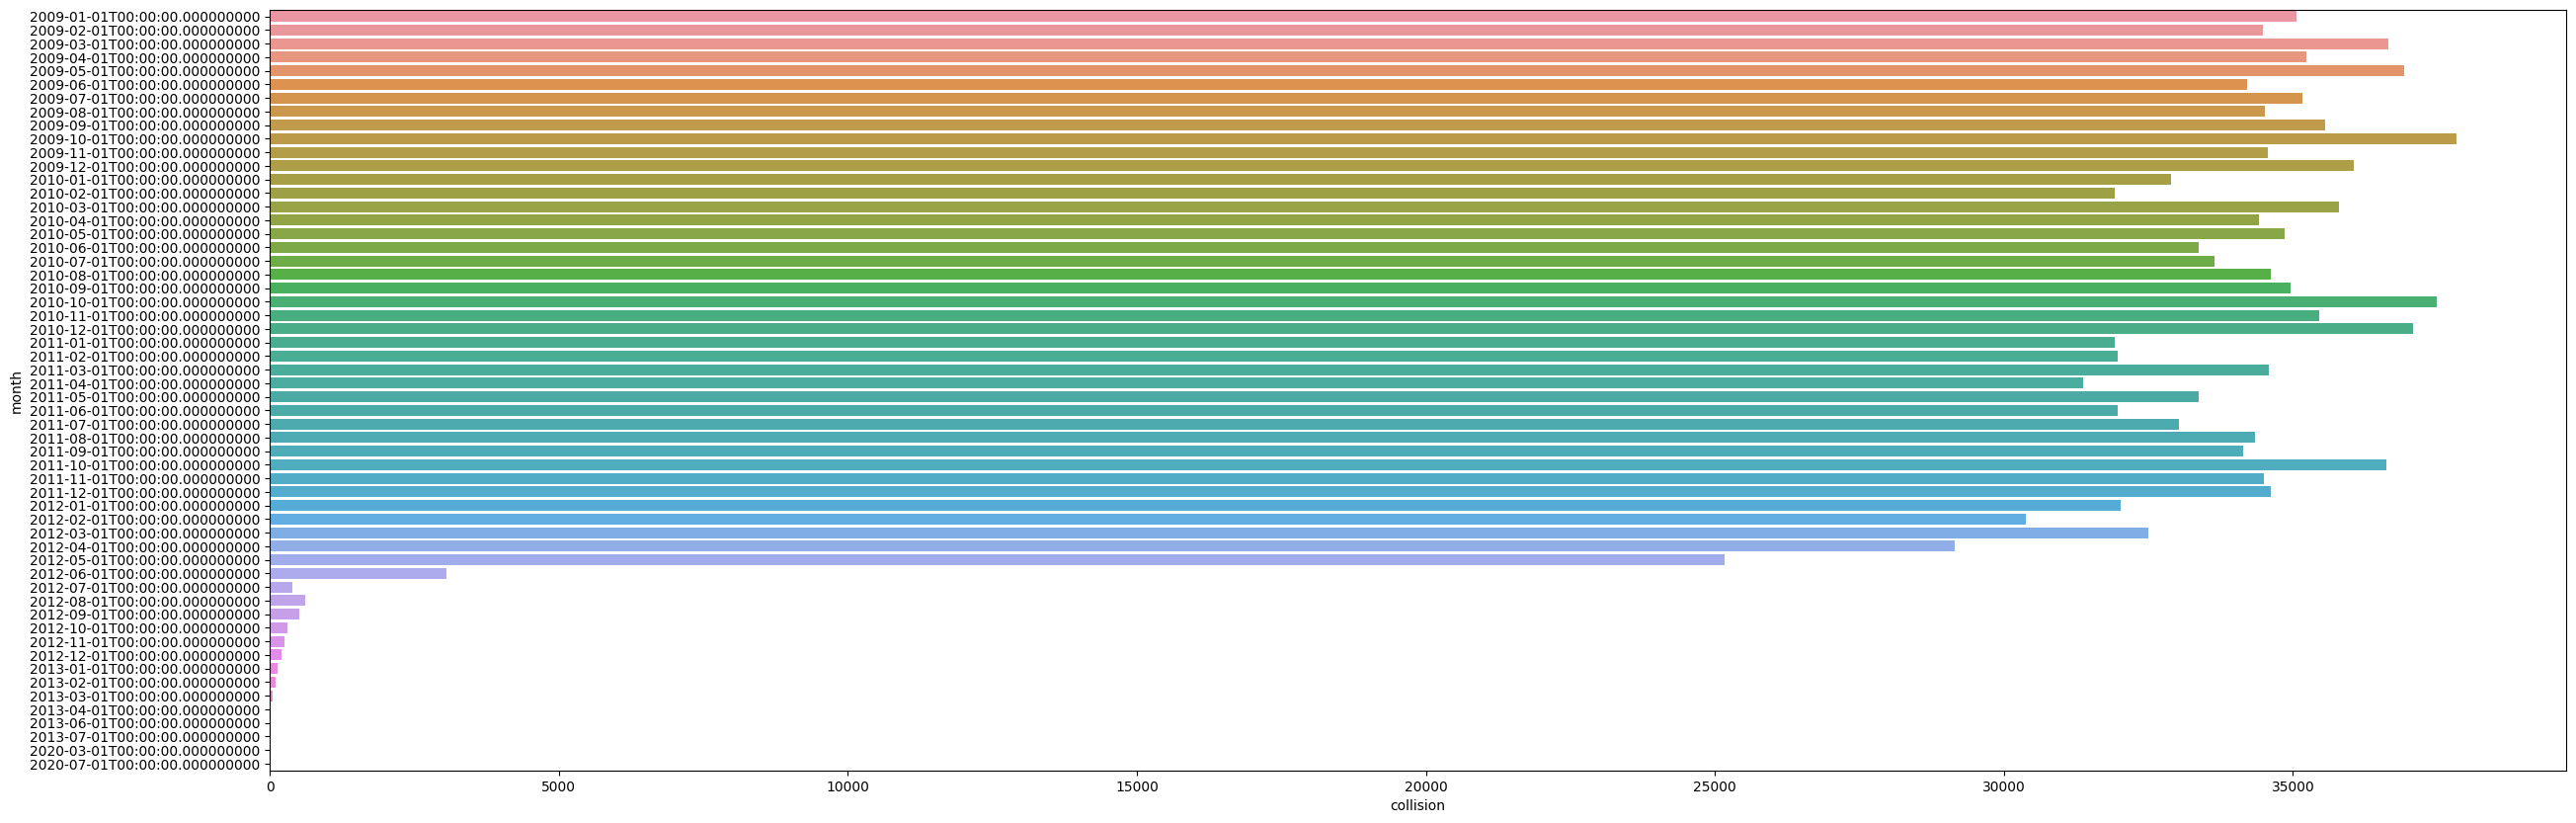

In [15]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select.sort_values(by='month'), y='month', x='collision', ax=ax);

На гистрограмме распределения видно, что начиная со второй половины 2012 года, данных становится сильно меньше, при этом существует разрыв начиная с 2013 года и до 2020. Ниже приведено распределение ДТП по временам года.

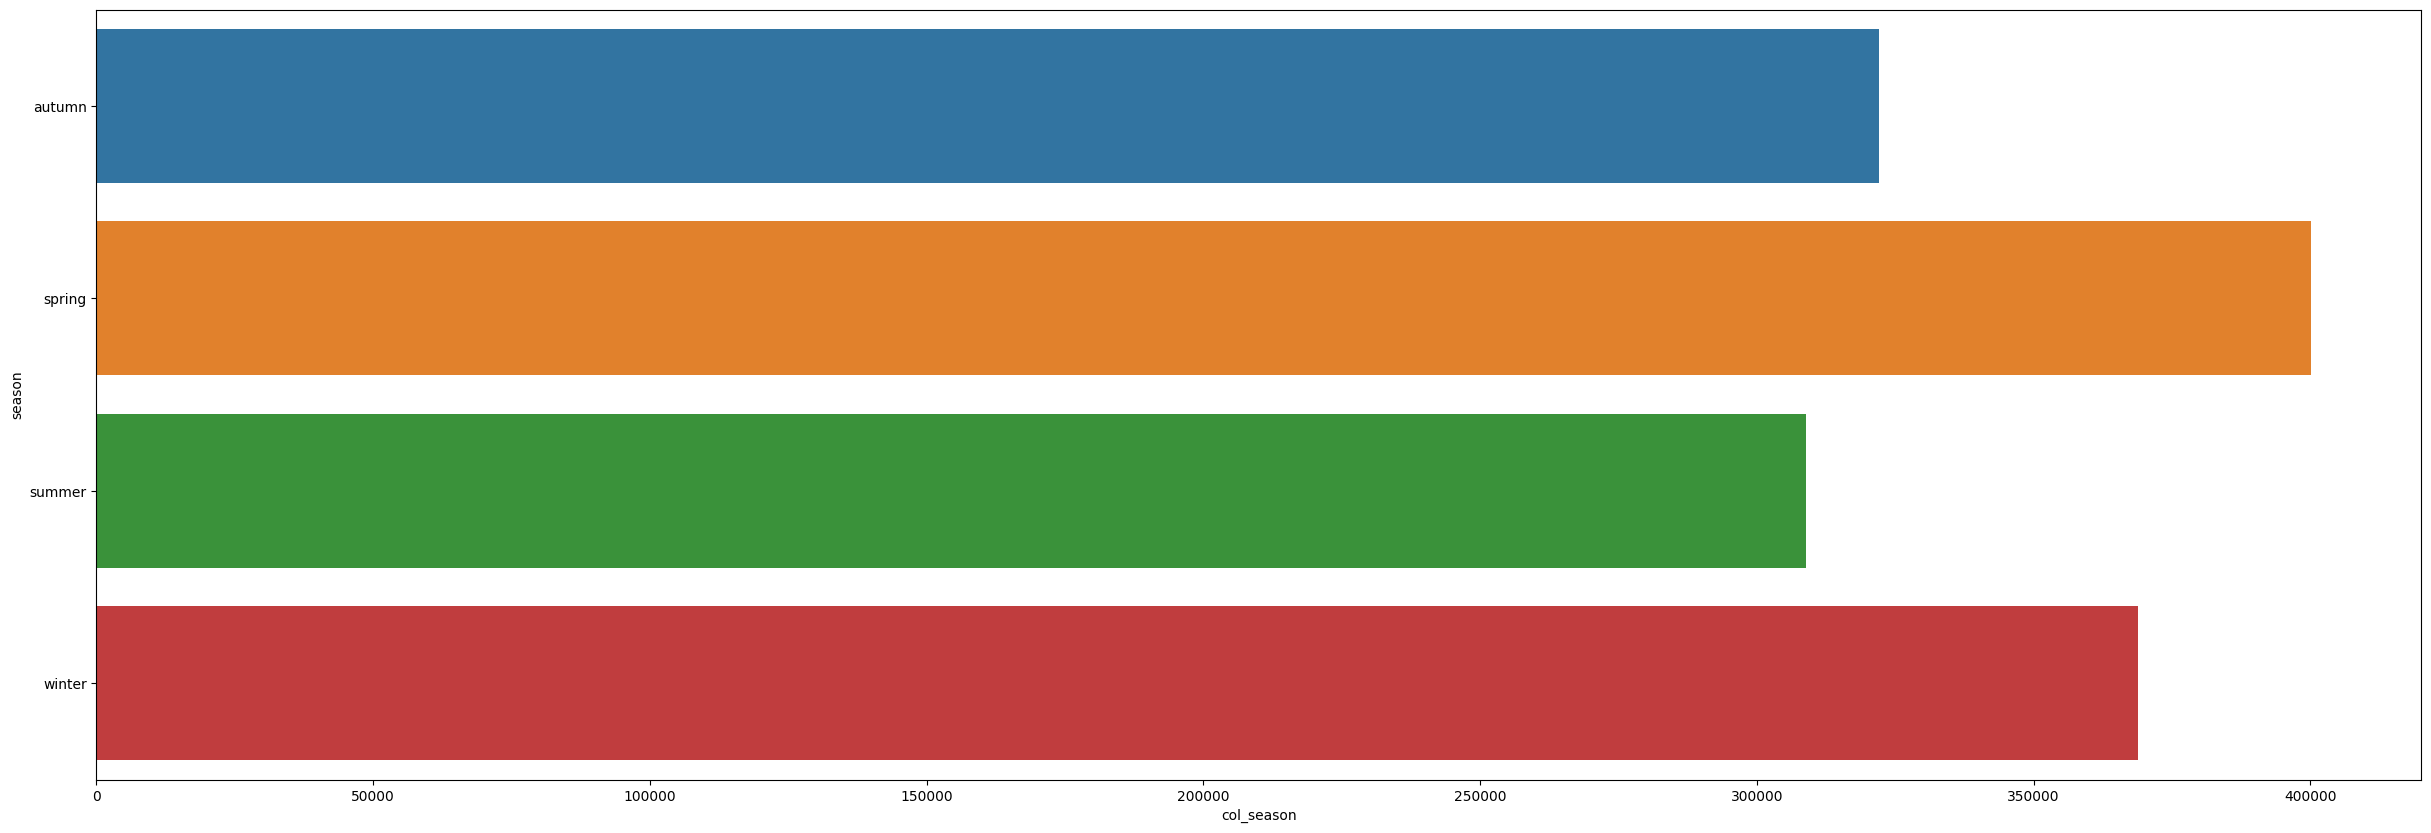

In [16]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select, y='season', x='col_season', ax=ax);

Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

## Аналитические задачи

- Определить распределение участников проишествия по типу;
- Определить корреляцию между основным фактором аварии и суммой страховки;
- Существует ли зависимость параметров автомобиля с суммой страховки;
- Есть ли связь с состоянием дороги и временем года;
- Оценить взудите диссперсии параметров в таблице "информация о происшествиях", существуют ли линейно дублирующие параметры в таблице;
- Оценить серьезность ущерба в зависимости от трезвости водителя.

### Распределение участников проишествия по типу

Из первичного обзора данных стало ясно, что в таблице есть не соответствие типов данных, а также пропуски в них. Выполним преобразование типов данных, для оптимизации потребления оперативной памяти и дальнейшей работы с данными.

In [17]:
sql_parties = """
SELECT *
FROM parties
"""

df = pd.read_sql_query(sql_parties, con=engine, index_col='id')

In [18]:
group_party_type = df.groupby('party_type')[['at_fault']].agg(['count'])

,at_fault
,count
party_type,
building,48649
car,2469314
other,8879
road bumper,173488
road signs,48456


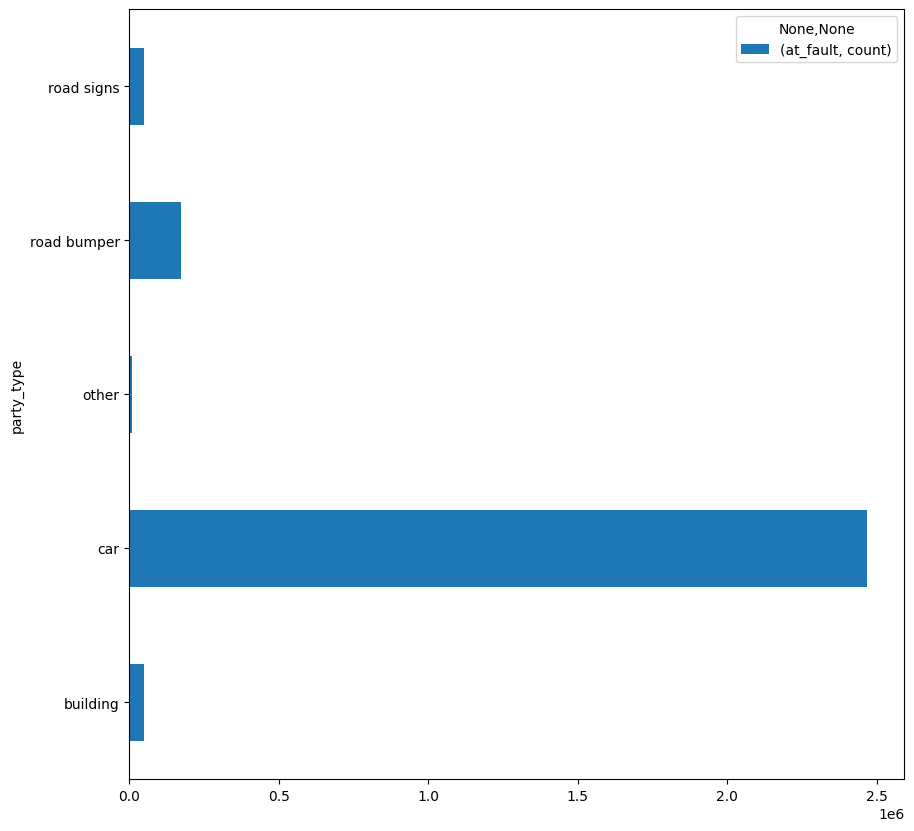

In [19]:
group_party_type.plot.barh(figsize=(10,10));
group_party_type

Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

### Зависимость параметров автомобиля с суммой страховки

In [20]:
sql_parties = """
SELECT p.at_fault AS fault,
        p.insurance_premium AS insurance,
        v.vehicle_type AS v_type,
        v.vehicle_transmission AS v_transmission,
        v.vehicle_age AS age
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id
"""

df = pd.read_sql_query(sql_parties, con=engine)

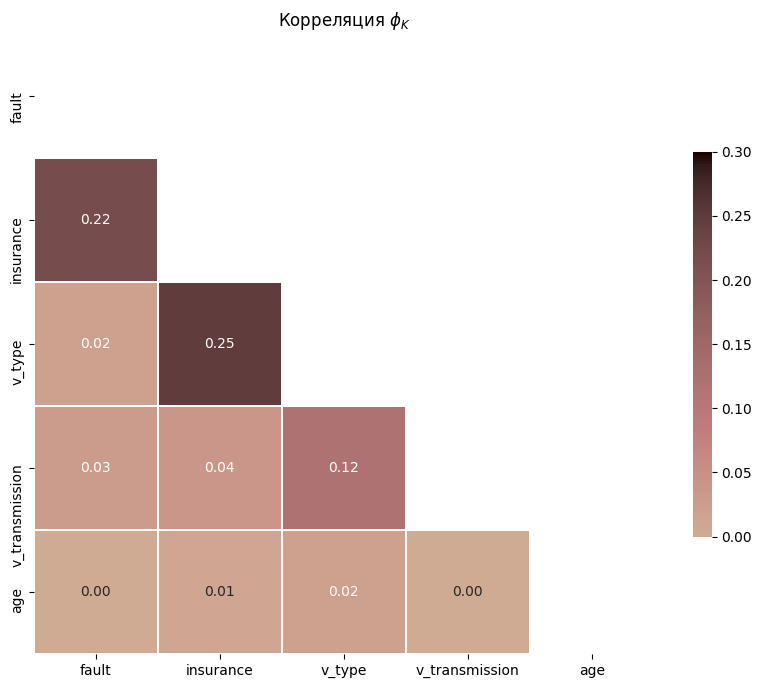

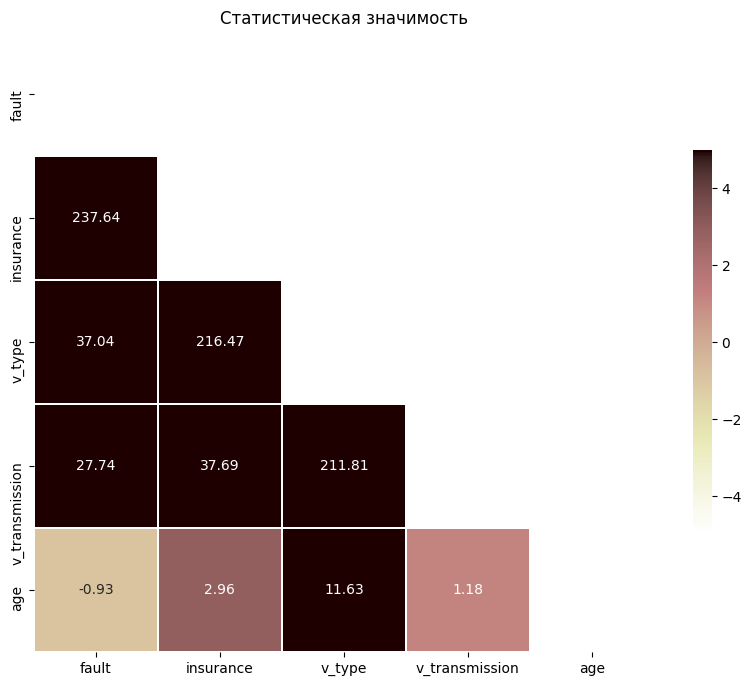

In [21]:
phik_sign(df)

Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, проверим есть ли зависимость между кузовом автомобиля, частотой его попадания в ДТП и размером страховки

In [22]:
sql_parties = """
WITH car AS (SELECT p.at_fault AS fault,
                    p.insurance_premium AS insurance,
                    v.vehicle_type AS v_type,
                    v.vehicle_transmission AS v_transmission,
                    v.vehicle_age AS age,
                    c.collision_date
            FROM parties AS p
            INNER JOIN vehicles AS v ON p.case_id = v.case_id
            INNER JOIN collisions AS c ON p.case_id = c.case_id)
SELECT fault,
        v_type,
        insurance,
        collision_date,
       COUNT(fault) OVER(PARTITION BY v_type) AS cnt_f,
       SUM(insurance) OVER(PARTITION BY v_type) AS sum_i
FROM car
"""

df = pd.read_sql_query(sql_parties, con=engine, parse_dates='collision_date')

In [23]:
df = df.drop_duplicates().reset_index(drop=True)
df = df.fillna(0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451592 entries, 0 to 451591
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fault           451592 non-null  int64         
 1   v_type          451592 non-null  object        
 2   insurance       451592 non-null  float64       
 3   collision_date  451592 non-null  datetime64[ns]
 4   cnt_f           451592 non-null  int64         
 5   sum_i           451592 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 20.7+ MB


**Расспределение количества ДТП для каждого типа кузова**

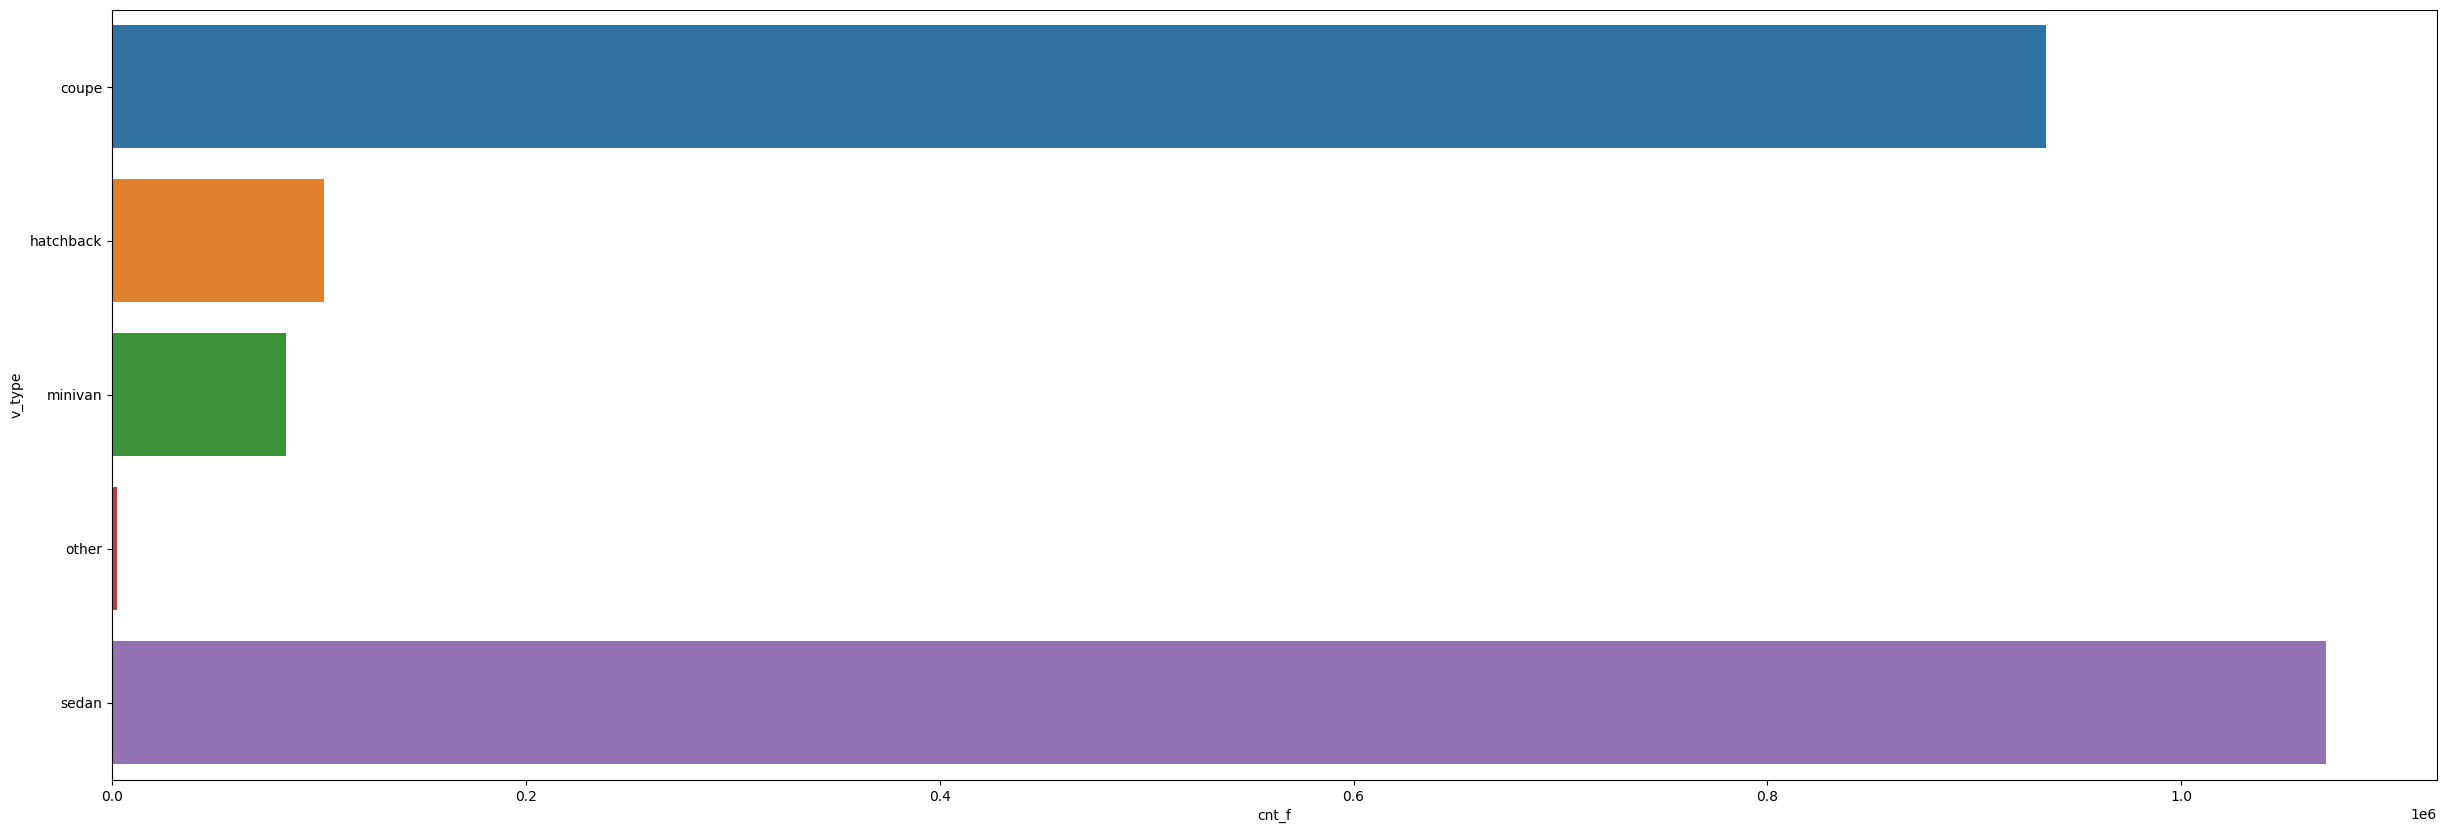

In [25]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='cnt_f', ax=ax);

**Расспределение суммы страховки и кузовом**

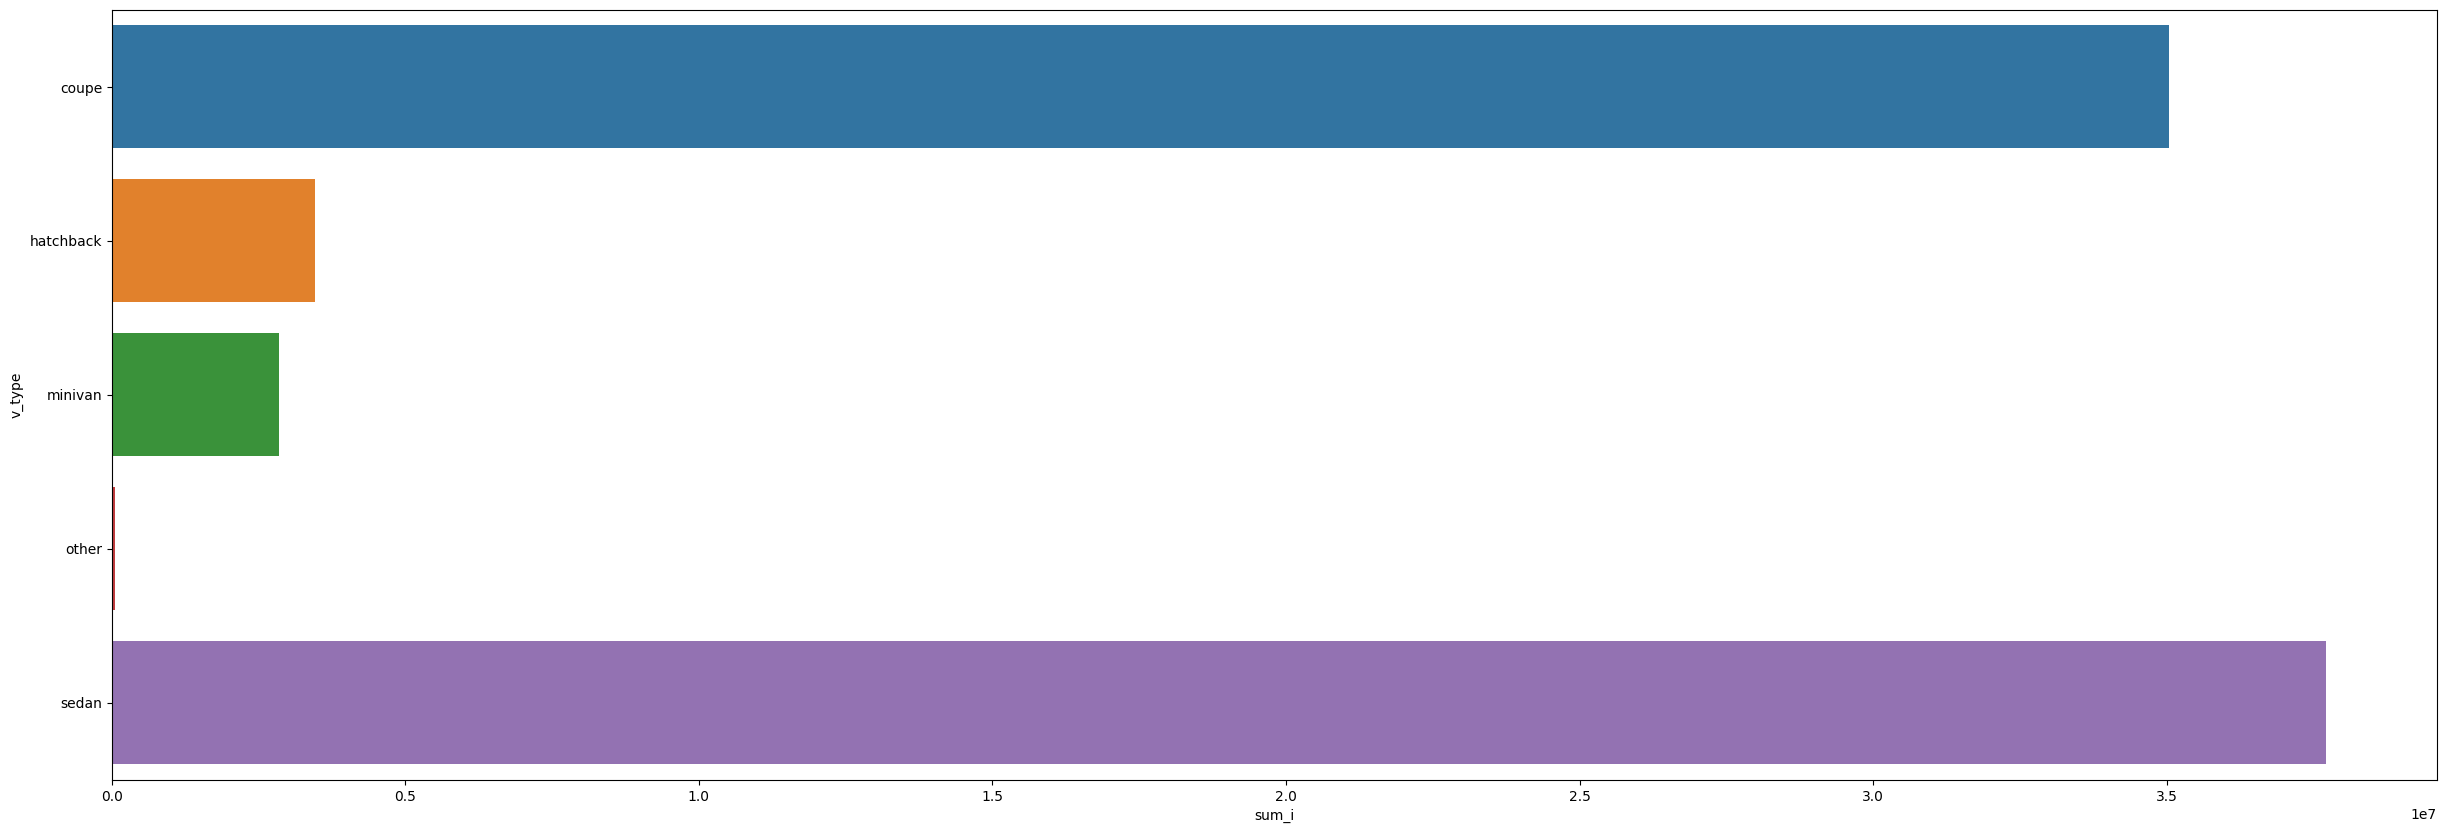

In [26]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='sum_i', ax=ax);

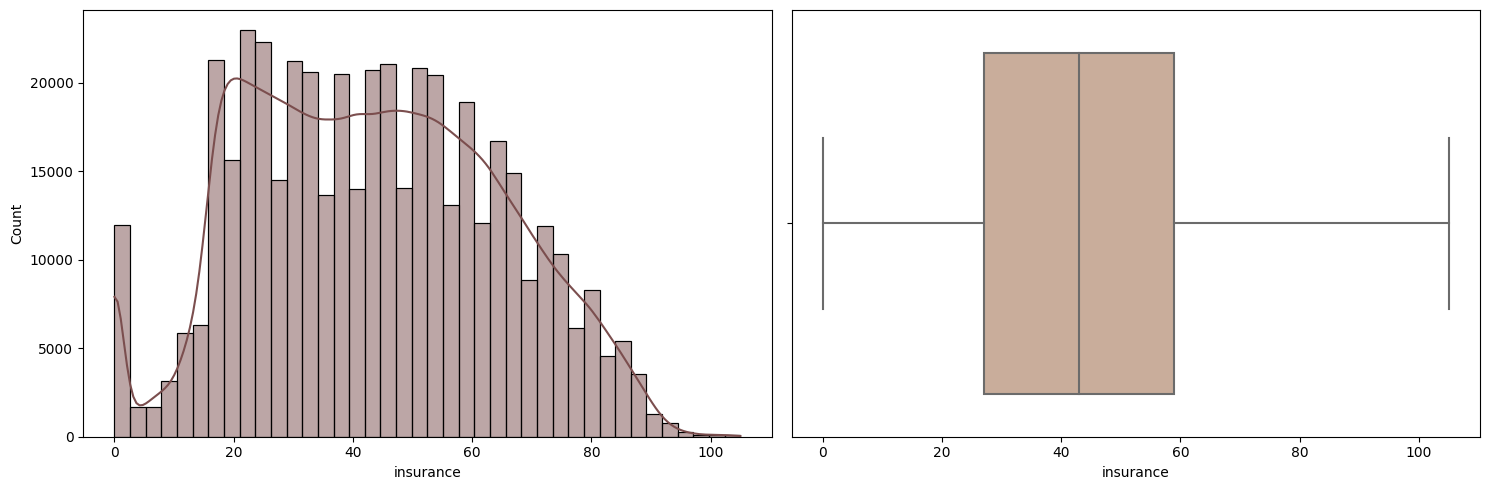

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance'], ax=axes[0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

По количеству аварий с лидирующие позиции занимают купе и седан они же имеют самые большие страховые взносы.

**Выводы**

- Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

- Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

- Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, анализ показал, что по количеству аварий лидирующие позиции занимают тип кузова купе и седан они же имеют самые большие страховые взносы.

# Оценка водительского риска

Подготовим данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавим новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

<AxesSubplot:>

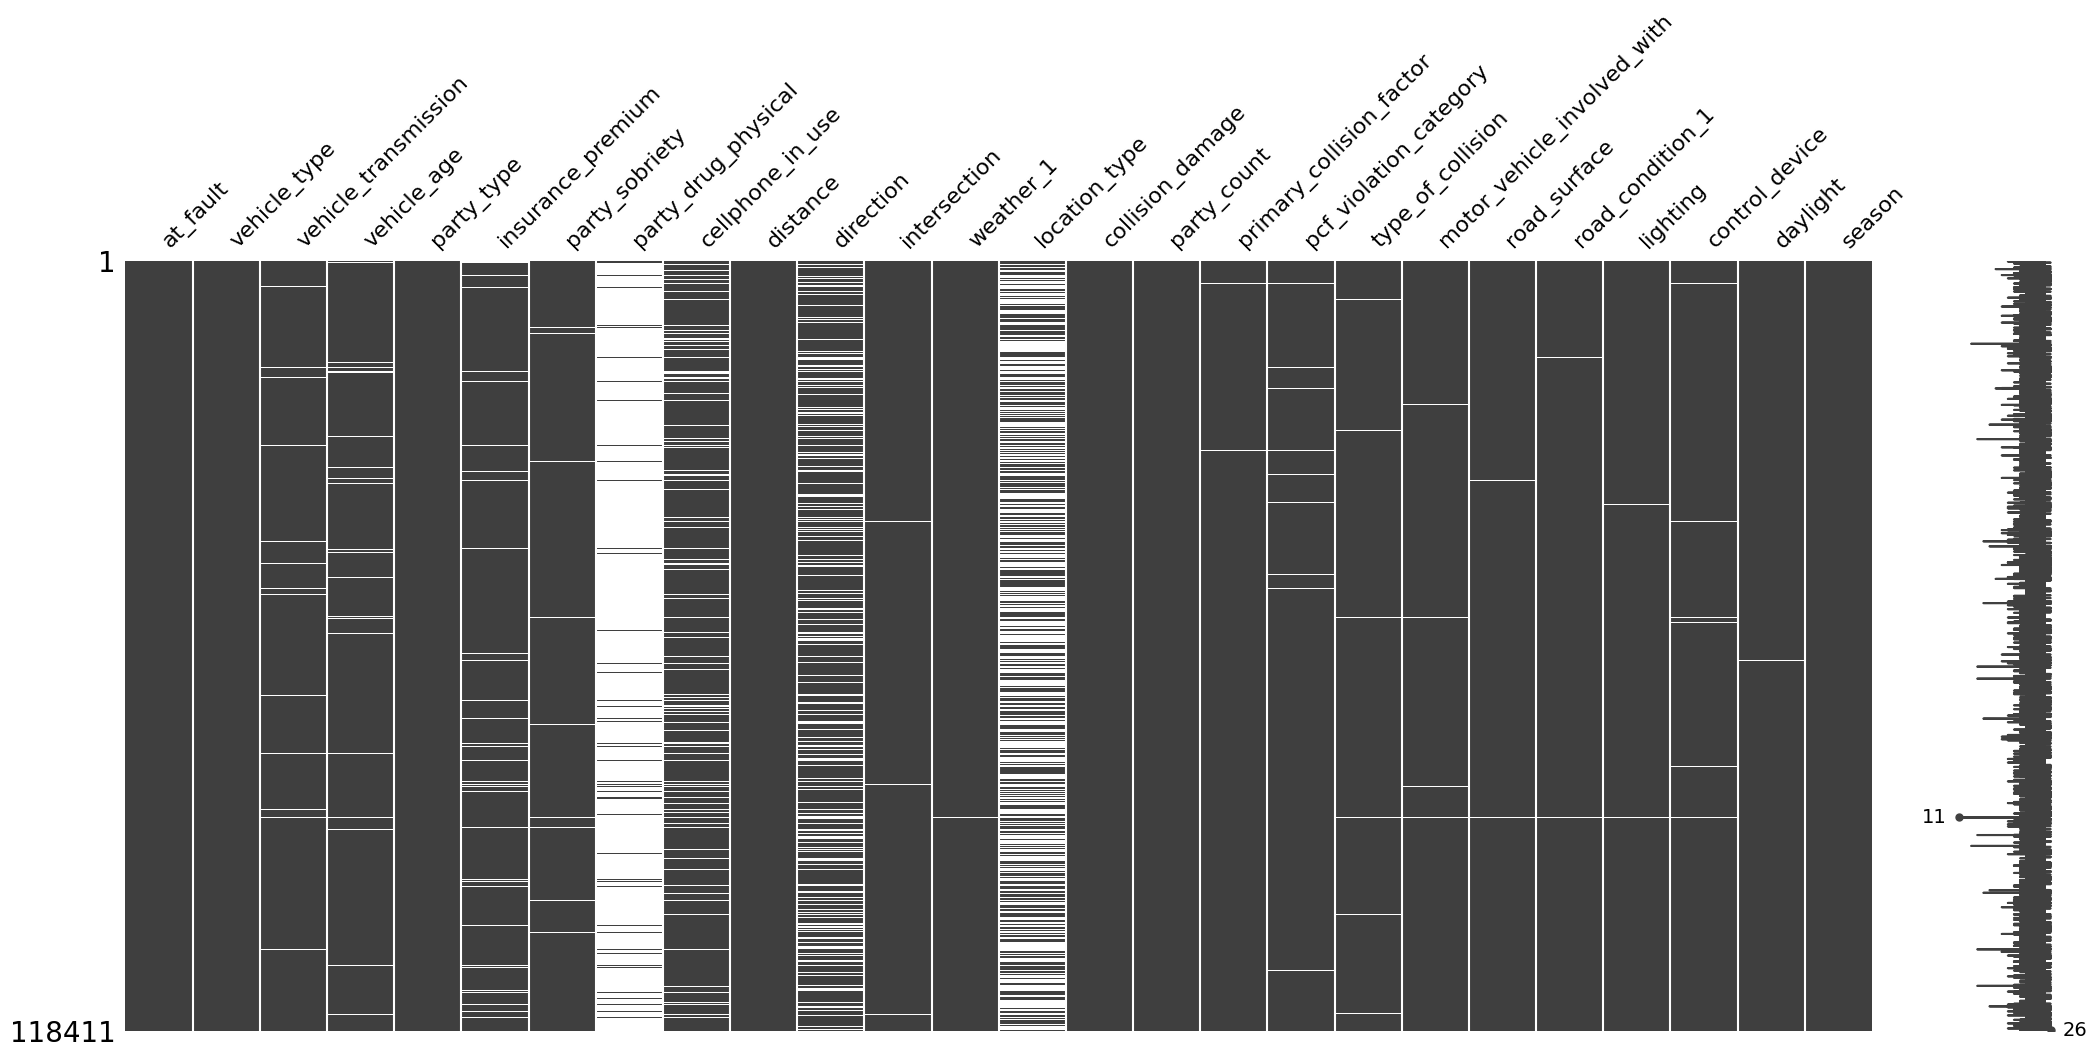

In [28]:
sql_query = '''
SELECT  at_fault,
		vehicle_type,
        vehicle_transmission,
        vehicle_age,
        party_type,
        insurance_premium,
        party_sobriety,
        party_drug_physical,
        cellphone_in_use,
        distance,
        direction,
        intersection,
        weather_1,
        location_type,
        collision_damage,
        party_count,
        primary_collision_factor,
        pcf_violation_category,
        type_of_collision,
        motor_vehicle_involved_with,
        road_surface,
        road_condition_1,
        lighting,
        control_device,
        daylight,
        season
FROM ((SELECT *,
            (CASE
                WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
            END) AS season,
            (CASE
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 0 AND 6 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'night'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 7 AND 12 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'morning'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 13 AND 18 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'day'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 19 AND 23 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'evening'
            END) AS daylight
	FROM collisions
	WHERE DATE_PART('year', collision_date) = 2012) AS c
	JOIN
	(SELECT *
	FROM parties
	WHERE party_type = 'car') AS p ON c.case_id = p.case_id
	JOIN
	(SELECT *
	FROM vehicles) AS v ON p.case_id = v.case_id)
WHERE collision_damage != 'scratch'
'''
#подключение к базе and p.party_number = v.party_number
df = pd.read_sql_query(sql_query, con=engine)
missingno.matrix(df)

In [29]:
info_df(df)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     118411 non-null  int64  
 1   vehicle_type                 118411 non-null  object 
 2   vehicle_transmission         116545 non-null  object 
 3   vehicle_age                  115046 non-null  float64
 4   party_type                   118411 non-null  object 
 5   insurance_premium            113289 non-null  float64
 6   party_sobriety               116682 non-null  object 
 7   party_drug_physical          8695 non-null    object 
 8   cellphone_in_use             107507 non-null  float64
 9   distance                     118411 non-null  float64
 10  direction                    89466 non-null   object 
 11  intersection            

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
0,0,sedan,manual,3.0,car,53.0,had not been drinking,None,0.0,1079.0,...,vehicle code violation,improper passing,broadside,other motor vehicle,dry,normal,daylight,none,morning,winter
1,0,coupe,manual,5.0,car,53.0,had not been drinking,None,0.0,1079.0,...,vehicle code violation,improper passing,broadside,other motor vehicle,dry,normal,daylight,none,morning,winter
2,0,sedan,manual,4.0,car,43.0,had not been drinking,None,0.0,120.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
3,1,sedan,manual,0.0,car,18.0,had not been drinking,None,0.0,200.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dusk or dawn,none,day,winter
4,1,sedan,auto,2.0,car,18.0,had not been drinking,None,0.0,200.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dusk or dawn,none,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,0,sedan,auto,4.0,car,28.0,had not been drinking,None,0.0,725.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,day,winter
118407,1,coupe,manual,7.0,car,23.0,had not been drinking,None,0.0,570.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with no street lights,none,evening,winter
118408,1,coupe,manual,3.0,car,23.0,had not been drinking,None,0.0,570.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with no street lights,none,evening,winter
118409,0,coupe,manual,7.0,car,46.0,had not been drinking,None,0.0,570.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with no street lights,none,evening,winter


--------------------
| Сумма дубликатов |
--------------------
2556
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['sedan' 'coupe' 'hatchback' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['manual' 'auto' None]
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['car']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'impairment unknown'
 'had been drinking, not under influence' None
 'had been drinking, under influence'
 'had been drinking, impairment unknown' 'not applicable']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'G' 'not applicable' '

In [30]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
at_fault,0.000000
vehicle_type,0.000000
vehicle_transmission,1.600000
vehicle_age,2.800000
party_type,0.000000
insurance_premium,4.300000
party_sobriety,1.500000
party_drug_physical,92.700000
cellphone_in_use,9.200000
distance,0.000000


Из первичного анализа видно, что в данных существую пропуски и не явные дубликаты. Выполним исследовательский анализ данных для выбора признаков.

## EDA

### vehicle_transmission

Можно предлополижить что разница в типе трансмиссии будет влиять на вероятность ДТП из-за неисправности.

Нулевая гипотеза звучит как: количество ДТП с механической КПП не отличается от автомобиля с автоматической КПП.

Альтернативная гипотеза: наличие механической коробки передач увеличивает количество ДТП.

Пропуски в данных заполнить не представляется возможным, так как тип кузова не может дать никакой информации о типе КПП, а другой технической информации о машине у нас нет. Процент пропуска от всего набора данных составляет 1.6% что не является серьезным значением, удалим пропуски.

In [31]:
df = df.loc[df['vehicle_transmission'].isna() == False]

In [32]:
# ДТП при РКПП
fault_manula = df.loc[df['vehicle_transmission'] == 'manual', 'at_fault']
# ДТП при АКПП
fault_auto = df.loc[df['vehicle_transmission'] == 'auto', 'at_fault']
# Уровень статистической значимости
alpha = .05

results = st.ttest_ind(fault_manula, fault_auto, alternative='greater')
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 4.2056519367994095e-19
Отвергаем нулевую гипотезу


Статестический тест показал, что тип коробки передач действительно влияет на количество аварий, скорее всего это свзязано с надежностью РКПП, оставим эти данные и преобразуем тип данных

In [33]:
df['vehicle_transmission'] = df['vehicle_transmission'].astype('category')

**Выбросы в данных**

Проверим данные на аномальные значения

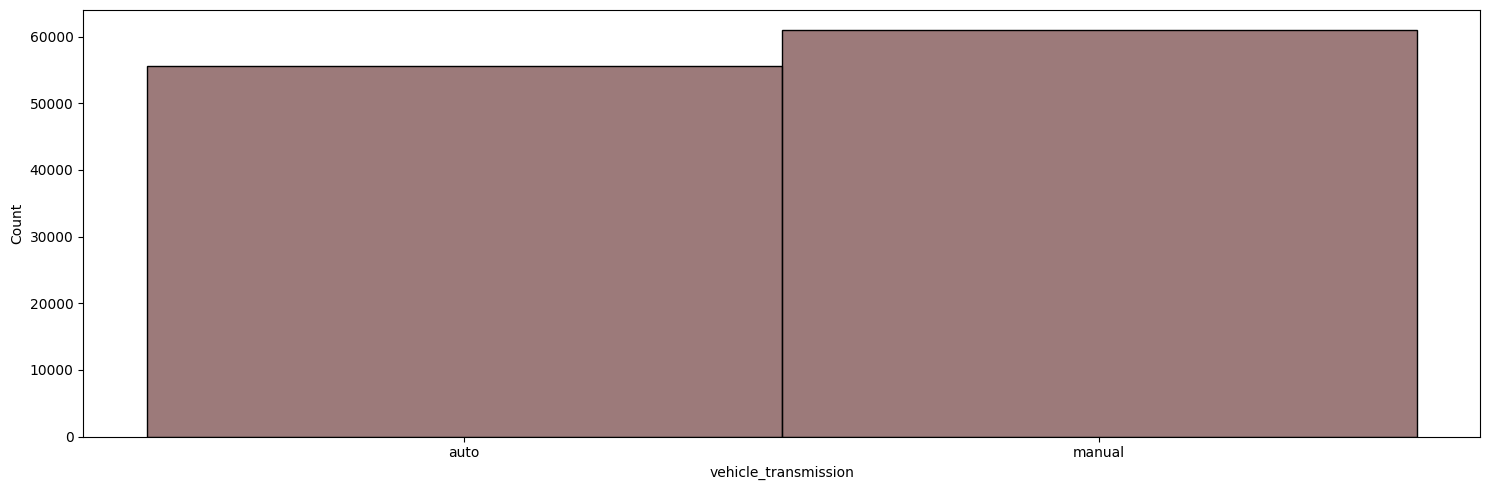

In [34]:
fig, axes = plt.subplots( figsize=(15, 5))
sns.histplot(df['vehicle_transmission'], bins=40, edgecolor='black', color=sns.color_palette("pink")[0])

plt.tight_layout()
plt.show()

Сильного дисбаланса нет

### vehicle_age

Основываясь на информации о известных суммах страховки для того или иного кузова авто, попробуем восстановить данные для пропущенных значений.

In [35]:
df.loc[df['vehicle_age'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
27,0,sedan,auto,NaN,car,31.0,had not been drinking,None,0.0,500.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,evening,spring
37,1,sedan,auto,NaN,car,46.0,had not been drinking,None,0.0,528.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,spring
230,1,sedan,auto,NaN,car,NaN,impairment unknown,G,0.0,500.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
231,0,sedan,auto,NaN,car,78.0,had not been drinking,None,0.0,500.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
237,0,sedan,manual,NaN,car,61.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118186,0,sedan,auto,NaN,car,23.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,hit object,non-collision,dry,normal,daylight,none,day,winter
118226,1,sedan,manual,NaN,car,55.0,had not been drinking,None,0.0,2640.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,day,summer
118228,0,sedan,manual,NaN,car,37.0,had not been drinking,None,0.0,2640.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,day,summer
118347,1,sedan,manual,NaN,car,23.0,had not been drinking,None,0.0,1000.0,...,vehicle code violation,speeding,sideswipe,other motor vehicle,wet,normal,dark with street lights,none,night,winter


In [36]:
(df.loc[df['vehicle_age'].isna() == False,
        ['insurance_premium', 'vehicle_type', 'vehicle_age']]
        .groupby('vehicle_type')[['insurance_premium', 'vehicle_age']]
        .agg({'median'}))

,insurance_premium,vehicle_age
,median,median
vehicle_type,,
coupe,37.0,5.0
hatchback,41.0,5.0
minivan,42.0,4.0
other,26.0,4.0
sedan,35.0,4.0


In [37]:
for v_type in df['vehicle_type'].unique():
    df.loc[(df['vehicle_type'] == v_type)
            & (df['vehicle_age'].isna() == True),'vehicle_age'] = \
    df.loc[(df['vehicle_type'] == v_type)
                   & (df['vehicle_age'].isna() == False),
                     'vehicle_age'].median()

**Выбросы в данных**

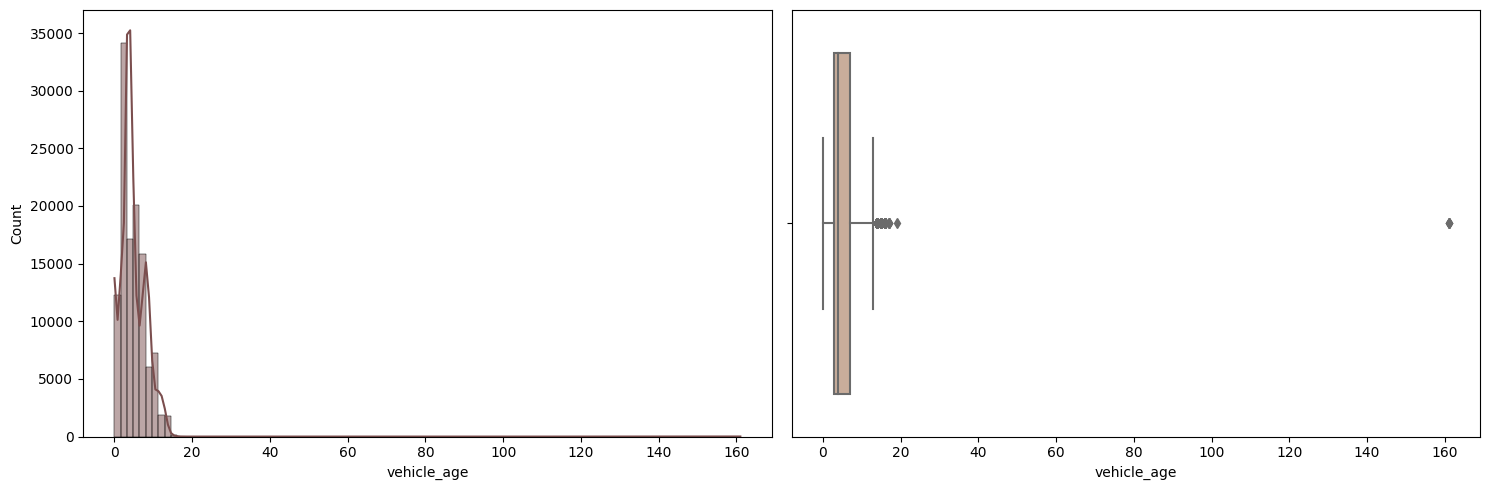

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

В признаке возраст авто присутсвуют аномальные значения в возрасте авто в 160 лет. Удалим эти данные

In [39]:
df = df.loc[df['vehicle_age'] <= 20]

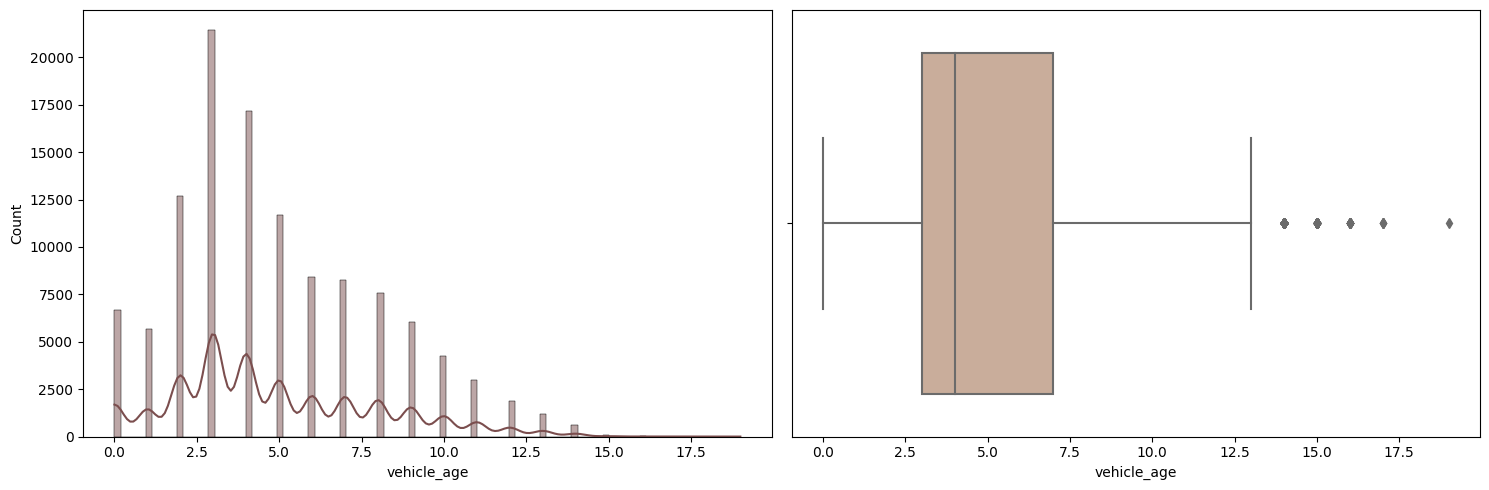

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [41]:
df['vehicle_age'] = df['vehicle_age'].astype('int8')

### insurance_premium

Проанализируем, какой из параметров больше влияет на стоимость страховки, тип кузова или возраст автомобиля.

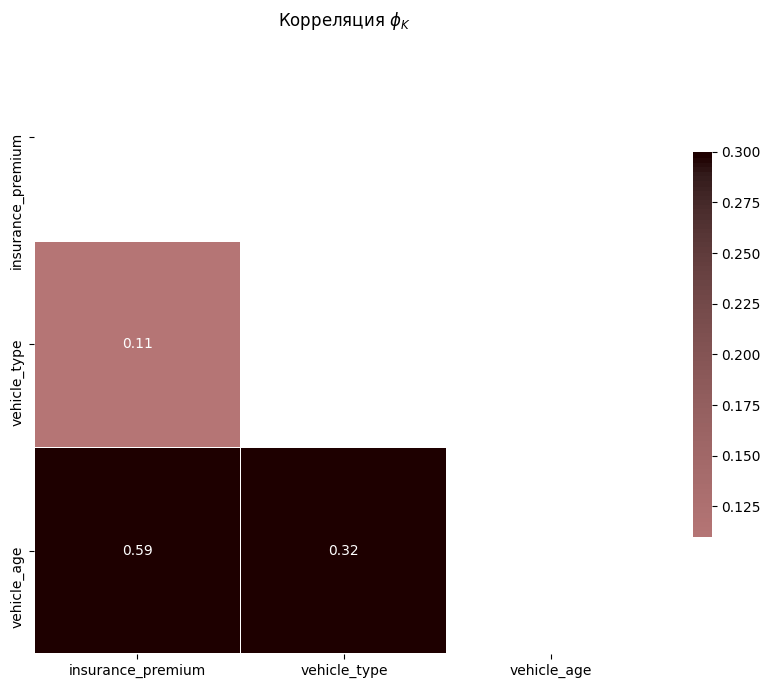

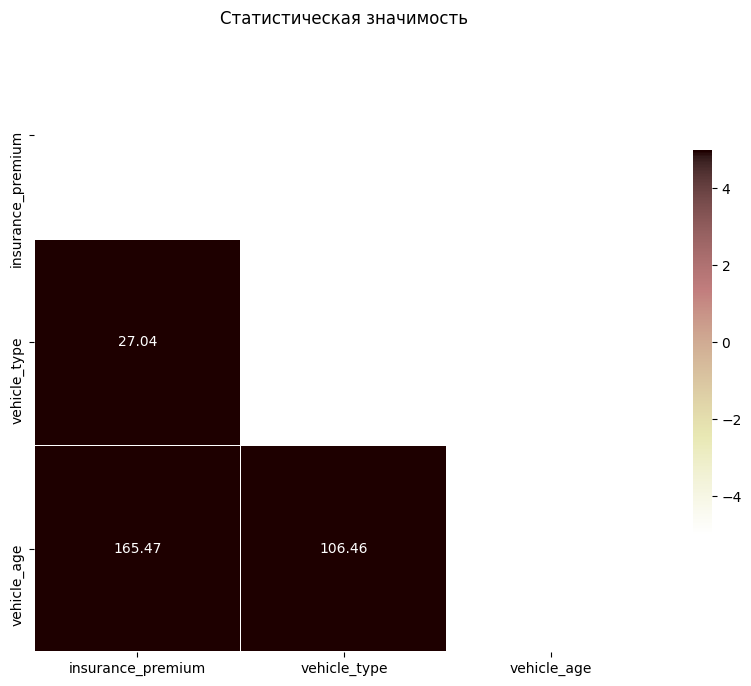

In [42]:
phik_sign(df.loc[df['insurance_premium'].isna() == False, ['insurance_premium', 'vehicle_type','vehicle_age']])

Из анализа корреляции и уровня статистической значимости, можно сказать, что тип возраст авто больше коррелирует с стоимостью страховки чем тип кузова.

In [43]:
df.loc[df['insurance_premium'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
9,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
21,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
28,1,sedan,manual,3,car,NaN,had not been drinking,None,1.0,147.0,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,spring
45,1,minivan,manual,7,car,NaN,impairment unknown,G,NaN,0.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,morning,spring
55,1,coupe,auto,3,car,NaN,impairment unknown,G,NaN,10560.0,...,vehicle code violation,unsafe lane change,overturned,non-collision,dry,normal,daylight,none,day,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118230,1,coupe,manual,6,car,NaN,impairment unknown,G,0.0,100.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,day,spring
118290,1,minivan,auto,5,car,NaN,impairment unknown,G,0.0,0.0,...,vehicle code violation,None,None,bicycle,dry,normal,daylight,none,day,spring
118297,1,minivan,manual,7,car,NaN,"had been drinking, impairment unknown",None,NaN,0.0,...,vehicle code violation,other hazardous violation,sideswipe,bicycle,dry,normal,daylight,none,day,spring
118298,1,minivan,manual,5,car,NaN,"had been drinking, impairment unknown",None,NaN,0.0,...,vehicle code violation,other hazardous violation,sideswipe,bicycle,dry,normal,daylight,none,day,spring


In [44]:
for v_type in df['vehicle_age'].unique():
    df.loc[(df['vehicle_age'] == v_type)
            & (df['insurance_premium'].isna() == True),'insurance_premium'] = \
    df.loc[(df['vehicle_age'] == v_type)
                   & (df['insurance_premium'].isna() == False),
                     'insurance_premium'].median()

**Выбросы в данных**

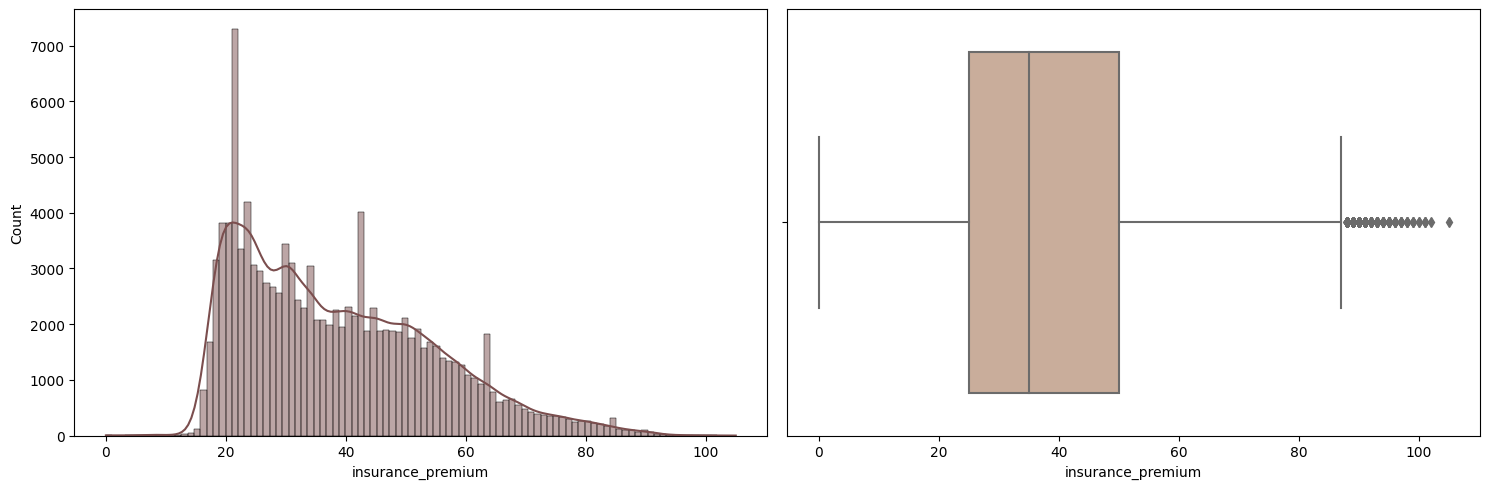

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance_premium'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance_premium'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [46]:
df['insurance_premium'] = df['insurance_premium'].astype('int8')

Выбросы в данных присутствуют, но их количество сильно меньше, чем значений входяших в распределение, оставим эти данные.

### party_sobriety

Данные о трезвости водителя, может являтся одним из ключевых параметров при обучении, но пропуски объемом в 1.6% можно удалить.

In [47]:
df.loc[df['party_sobriety'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
15,0,sedan,auto,3,car,37,None,None,NaN,1000.0,...,vehicle code violation,unsafe lane change,hit object,fixed object,dry,normal,daylight,none,morning,winter
56,1,hatchback,manual,0,car,24,None,None,0.0,4.0,...,vehicle code violation,speeding,other,other object,wet,normal,daylight,none,day,spring
67,1,sedan,manual,2,car,22,None,None,0.0,113.0,...,vehicle code violation,speeding,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,spring
74,0,sedan,manual,0,car,35,None,None,0.0,120.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,morning,spring
75,0,sedan,auto,9,car,35,None,None,0.0,120.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,morning,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118131,0,sedan,auto,2,car,28,None,None,0.0,408.0,...,vehicle code violation,automobile right of way,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,evening,spring
118132,0,coupe,auto,4,car,28,None,None,0.0,408.0,...,vehicle code violation,automobile right of way,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,evening,spring
118237,1,sedan,auto,11,car,80,None,impairment - physical,0.0,281.0,...,vehicle code violation,improper turning,sideswipe,parked motor vehicle,dry,normal,dark with street lights,none,day,spring
118370,1,coupe,auto,6,car,28,None,under drug influence,NaN,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,daylight,functioning,morning,winter


In [48]:
df = df.loc[df['party_sobriety'].isna() == False]

In [49]:
df['party_sobriety'] = df['party_sobriety'].astype('category')

### party_drug_physical

Состояние участника: физическое или с учётом принятых лекарств так же как и предыдущий потенциально может быть важен для анализа, но объем пропущенных значений черезмерно велик, а существущие записи не репрезентативны для восстановления пропусков, предлагается пробелы заполнить значениями `G` = Impairment Unknown

In [50]:
df.loc[df['party_drug_physical'].isna() == False]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
9,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
21,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
45,1,minivan,manual,7,car,45,impairment unknown,G,NaN,0.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,morning,spring
55,1,coupe,auto,3,car,24,impairment unknown,G,NaN,10560.0,...,vehicle code violation,unsafe lane change,overturned,non-collision,dry,normal,daylight,none,day,spring
62,0,sedan,auto,5,car,34,impairment unknown,G,NaN,300.0,...,vehicle code violation,unsafe lane change,broadside,other motor vehicle,dry,normal,daylight,none,day,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118290,1,minivan,auto,5,car,34,impairment unknown,G,0.0,0.0,...,vehicle code violation,None,None,bicycle,dry,normal,daylight,none,day,spring
118309,1,coupe,manual,5,car,21,"had been drinking, under influence",under drug influence,0.0,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter
118310,1,coupe,manual,3,car,21,"had been drinking, under influence",under drug influence,0.0,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter
118330,0,minivan,manual,6,car,40,impairment unknown,G,0.0,0.0,...,vehicle code violation,traffic signals and signs,broadside,bicycle,dry,normal,dark with street lights,functioning,day,winter


In [51]:
df.loc[df['party_drug_physical'].isna() == True, 'party_drug_physical'] = 'G'

In [52]:
df['party_drug_physical'] = df['party_drug_physical'].astype('category')

### cellphone_in_use

Информация о том пользовался ли водитель телефоном или нет, также потенциально очень важна для построения модели, пропуски в данных заполним 0

In [53]:
df.loc[df['cellphone_in_use'].isna() == True, 'cellphone_in_use'] = 0
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int8')

### direction

Восстановить значения направлений движений также не представляется возможным, предлагается перекодировать значения направлений с 1 до 4, а для пустых значений присвоим 0

In [54]:
direction = {'north' : 1, 'east' : 2, 'west': 3, 'south': 4}

df['direction'].replace(direction, inplace=True)

In [55]:
df.loc[df['direction'].isna() == True, 'direction'] = 0
df['direction'] = df['direction'].astype('int8')

### intersection и weather_1

Объем пропусков для каждого признака на уровне 0.3% от общего объема, таким пропуском можно принебречь

In [56]:
df = df.loc[df['intersection'].isna() == False]
df = df.loc[df['weather_1'].isna() == False]

In [57]:
df['intersection'] = df['intersection'].astype('int8')
df['weather_1'] = df['weather_1'].astype('category')

### location_type

Пропуски в типе дороге заполним `other`

In [58]:
df['location_type'] = df['location_type'].fillna('other')
df['location_type'] = df['location_type'].astype('category')


### Пропуски данных менее 1.5%

Для признаков у которых имеются пропуски в данных на уровне менее 1.5% предлагается удалить пропуски.

In [59]:
df = df.loc[df['primary_collision_factor'].isna() == False]
df = df.loc[df['pcf_violation_category'].isna() == False]
df = df.loc[df['type_of_collision'].isna() == False]
df = df.loc[df['motor_vehicle_involved_with'].isna() == False]
df = df.loc[df['road_surface'].isna() == False]
df = df.loc[df['road_condition_1'].isna() == False]
df = df.loc[df['lighting'].isna() == False]
df = df.loc[df['control_device'].isna() == False]
df = df.loc[df['daylight'].isna() == False]

## Преобразование типов данных и удаление дубликатов

Оптимизируем типы данных для признаков

In [60]:
df[['at_fault', 'party_count']] = df[['at_fault', 'party_count']].astype('int8')
df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']] = \
    df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']].astype('category')

In [61]:
df['distance'] = df['distance'].astype('int16')

Еще раз взглянем на статистику по нашим данным

In [62]:
df.describe()

,at_fault,vehicle_age,insurance_premium,cellphone_in_use,distance,direction,intersection,party_count
count,110472.000000,110472.000000,110472.000000,110472.00000,110472.000000,110472.000000,110472.000000,110472.000000
mean,0.468671,4.874719,38.494632,0.01939,677.314161,1.905243,0.228664,2.358308
std,0.499020,3.096134,16.133074,0.13789,1936.197156,1.471893,0.419974,0.948894
min,0.000000,0.000000,0.000000,0.00000,-31744.000000,0.000000,0.000000,1.000000
25%,0.000000,3.000000,25.000000,0.00000,5.000000,1.000000,0.000000,2.000000
50%,0.000000,4.000000,35.000000,0.00000,125.000000,2.000000,0.000000,2.000000
75%,1.000000,7.000000,50.000000,0.00000,528.000000,3.000000,0.000000,3.000000
max,1.000000,19.000000,105.000000,1.00000,32736.000000,4.000000,1.000000,10.000000


Видно что было упущено аномальное значение для параметра `distance`. Однозначно определить предельно возможное расстояние до главное дороги затруднительно, исходя из анализа статей ([ГОСТ Р 58653-2019](https://files.stroyinf.ru/Data2/1/4293725/4293725783.htm?ysclid=lrupvso19e520973235#i52115) и [Interstate Highway standards](https://translated.turbopages.org/proxy_u/en-ru.ru.3f185375-65b3bd3d-2e88835d-74722d776562/https/en.wikipedia.org/wiki/Interstate_Highway_standards)), можно сделать предположение, что ограничение в два стандартных отклонения может быть решением.

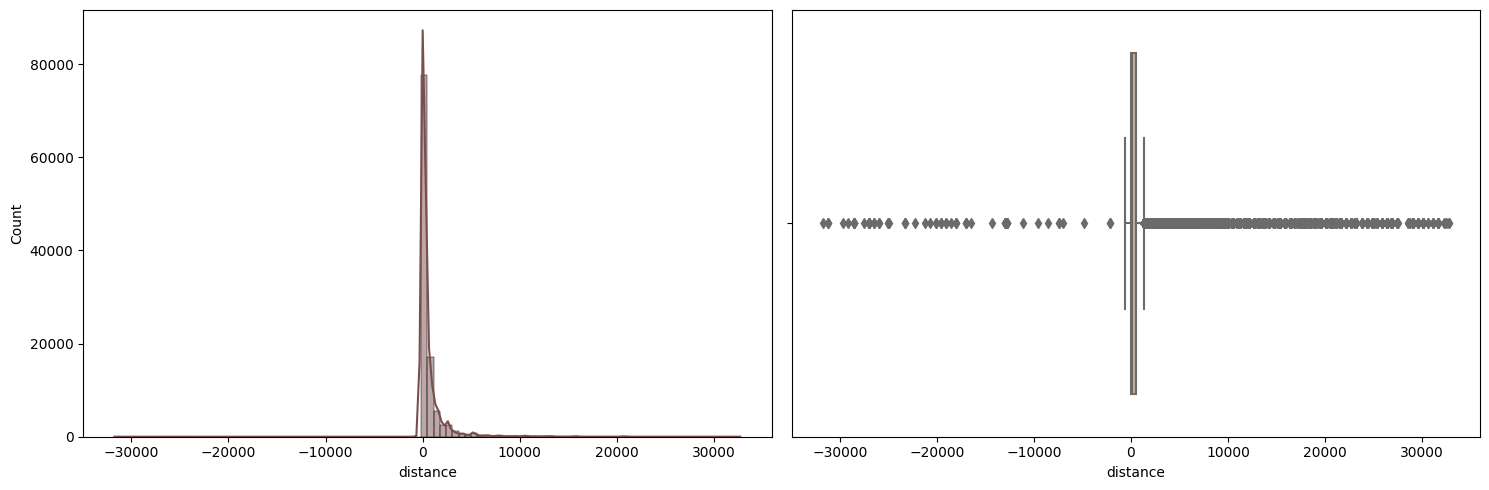

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [64]:
df['distance'] = df['distance'].abs()
df = df.loc[df['distance'] < df['distance'].std()*.05]

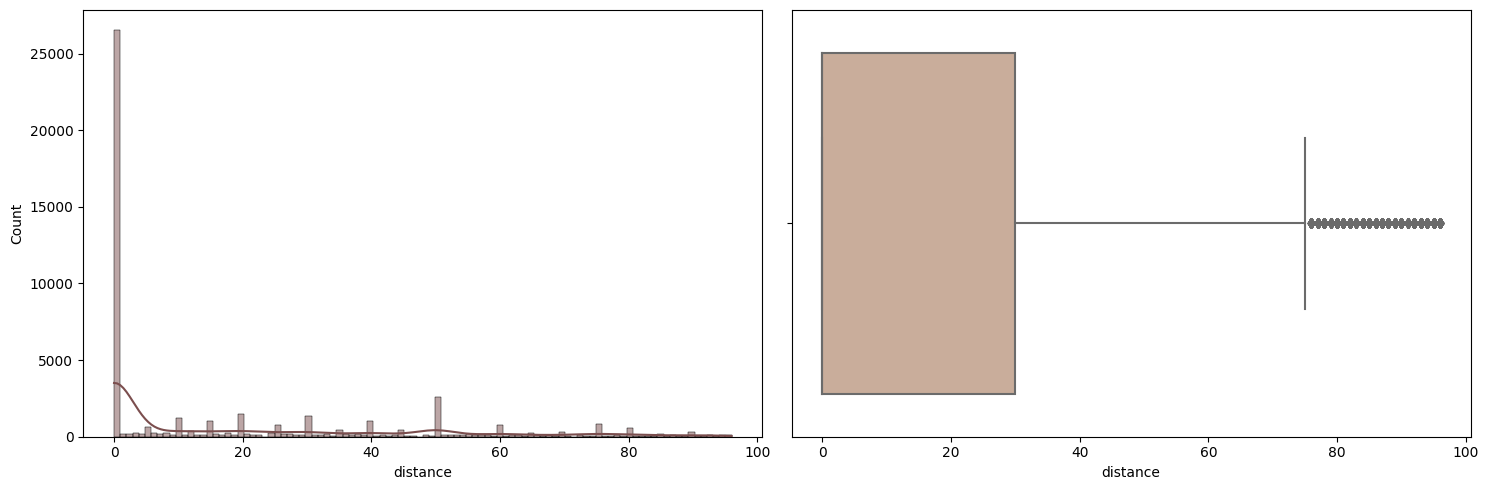

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [66]:
df = df.drop_duplicates().reset_index(drop=True)

# Подготовка признаков

In [67]:
target = df['at_fault']
features = df.drop('at_fault', axis=1)

In [68]:
features_train, features_test, target_train, target_test \
    = train_test_split(features, target, test_size = 0.25, random_state = RANDOM_STATE)

## Кодирование категориальных данных

In [69]:
ohe_features = features.select_dtypes(include='category').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='category').columns.to_list()
num_features

['vehicle_type', 'vehicle_transmission', 'party_type', 'party_sobriety', 'party_drug_physical', 'weather_1', 'location_type', 'collision_damage', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'daylight', 'season']


['vehicle_age',
 'insurance_premium',
 'cellphone_in_use',
 'distance',
 'direction',
 'intersection',
 'party_count']

In [70]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_ohe_train = features_train.copy()

encoder_ohe.fit(features_ohe_train[ohe_features])

transformed = encoder_ohe.transform(features_ohe_train[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_train.index)

features_ohe_train = pd.concat([features_ohe_train, ohe_df], axis=1).drop(ohe_features, axis=1)

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [71]:
features_ohe_test = features_test.copy()
transformed = encoder_ohe.transform(features_ohe_test[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_test.index)

features_ohe_test = pd.concat([features_ohe_test, ohe_df], axis=1).drop(ohe_features, axis=1)

## Анализ мультиколлениарности

In [72]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_ohe_train.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_ohe_train.values, i) \
                          for i in range(len(features_ohe_train.columns))]

print(vif_data)

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


              feature        VIF
0         vehicle_age   1.216570
1   insurance_premium   1.161242
2    cellphone_in_use   1.008662
3            distance   2.128353
4           direction   3.048753
..                ...        ...
88   daylight_morning   1.233469
89     daylight_night   1.754957
90      season_spring  22.364654
91      season_summer   3.425279
92      season_winter  21.664219

[93 rows x 2 columns]


In [73]:
VIF_features_drop = vif_data.query('VIF > 9.0')['feature']
VIF_features_drop

13    party_sobriety_had been drinking, under influence
14                 party_sobriety_had not been drinking
15                    party_sobriety_impairment unknown
16                        party_sobriety_not applicable
18                   party_drug_physical_not applicable
30                       collision_damage_middle damage
32                        collision_damage_small damage
33           primary_collision_factor_other than driver
34                     primary_collision_factor_unknown
35      primary_collision_factor_vehicle code violation
46        pcf_violation_category_other improper driving
47    pcf_violation_category_other than driver (or p...
52                       pcf_violation_category_unknown
62                  motor_vehicle_involved_with_bicycle
63             motor_vehicle_involved_with_fixed object
64    motor_vehicle_involved_with_motor vehicle on o...
65            motor_vehicle_involved_with_non-collision
66      motor_vehicle_involved_with_other motor 

In [74]:
features_ohe_train = features_ohe_train.drop(VIF_features_drop.values, axis=1)
features_ohe_test = features_ohe_test.drop(VIF_features_drop.values, axis=1)

# Baseline

In [117]:
def metrics(target, prediction, prediction_proba):
    print("Матрица ошибок")
    print(confusion_matrix(target, prediction))
    print("F1-score:",f1_score(target, prediction))
    print("AUC-ROC:", roc_auc_score(target, prediction_proba[:, 1]))
    fpr, tpr, thresholds = roc_curve(target, prediction_proba[:, 1])
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

## Log

In [75]:
model_lr = LogisticRegression(random_state = RANDOM_STATE, solver='liblinear', class_weight='balanced')

start_time_lr = time()

model_lr.fit(features_ohe_train, target_train)

end_time_lr = time()

lr_model_time_fit = (end_time_lr-start_time_lr) / 60

In [76]:
print('Время обучение модели: {0:.5f} сек.'. format(lr_model_time_fit))

Время обучение модели: 0.00410 сек.


In [77]:
start_time_lr = time()
predicted = model_lr.predict(features_ohe_train)
end_time_lr = time()

lr_model_time_predict = (end_time_lr-start_time_lr) / 60

In [78]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(lr_model_time_predict))

Время прогнозирования модели: 0.00018 сек.


Матрица ошибок
[[12195  7069]
 [ 7012  9740]]
F1-score: 0.5804356246834123
AUC-ROC: 0.6608205527772556


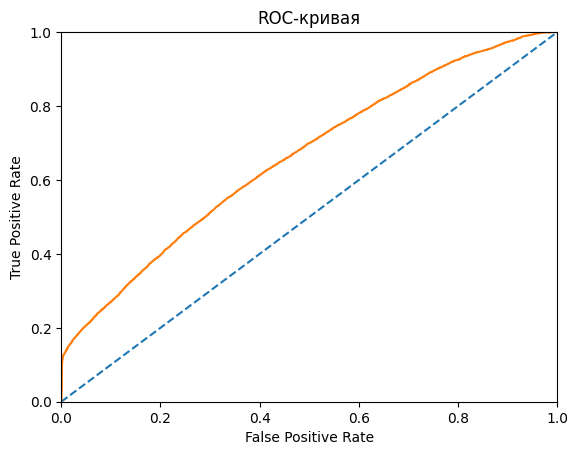

In [118]:
metrics(target_train, model_lr.predict(features_ohe_train), model_lr.predict_proba(features_ohe_train))

## Decision Tree

In [82]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10,
                                min_samples_leaf = 2, class_weight='balanced')

start_time_dt = time()

model_dt.fit(features_ohe_train, target_train)

end_time_dt = time()

dt_model_time_fit = (end_time_dt-start_time_dt) / 60

In [83]:
print('Время обучение модели: {0:.5f} сек.'. format(dt_model_time_fit))

Время обучение модели: 0.00237 сек.


In [84]:
start_time_dt = time()
predicted = model_dt.predict(features_ohe_train)
end_time_dt = time()

dt_model_time_predict = (end_time_dt-start_time_dt) / 60

In [85]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(dt_model_time_predict))

Время прогнозирования модели: 0.00040 сек.


Матрица ошибок
[[13097  6167]
 [ 6946  9806]]
F1-score: 0.5992971734148206
AUC-ROC: 0.6981262864160416


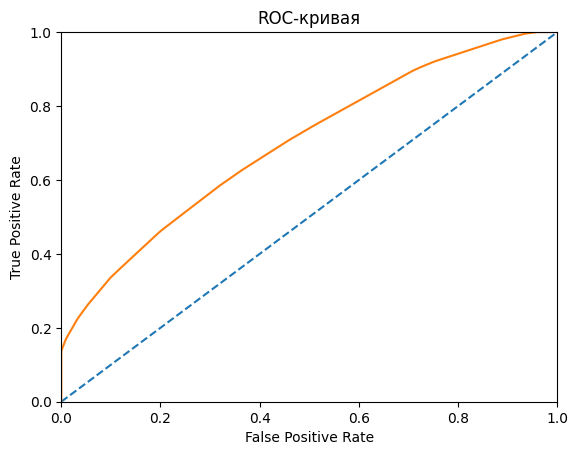

In [119]:
metrics(target_train, model_dt.predict(features_ohe_train), model_dt.predict_proba(features_ohe_train))

## CatBoost

In [92]:
cat_features = ohe_features

In [101]:
start_time_cat = time()
cat_model = CatBoostClassifier(loss_function='Logloss',
                                      depth=10,
                                      learning_rate=0.1,
                                      random_state=RANDOM_STATE,
                                      task_type="GPU",
                                      cat_features=cat_features,
                                      ).fit(features_train, target_train,
                                            plot=True, verbose=True)
end_time_cat = time()

cat_model_time_fit = (end_time_cat-start_time_cat) / 60

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6560579	total: 699ms	remaining: 11m 38s
1:	learn: 0.6279821	total: 1.37s	remaining: 11m 22s
2:	learn: 0.6073808	total: 2.02s	remaining: 11m 10s
3:	learn: 0.5923701	total: 2.65s	remaining: 11m
4:	learn: 0.5807839	total: 3.26s	remaining: 10m 49s
5:	learn: 0.5722564	total: 3.85s	remaining: 10m 37s
6:	learn: 0.5644780	total: 4.44s	remaining: 10m 29s
7:	learn: 0.5588979	total: 5.06s	remaining: 10m 27s
8:	learn: 0.5545315	total: 5.65s	remaining: 10m 21s
9:	learn: 0.5508468	total: 6.24s	remaining: 10m 18s
10:	learn: 0.5470573	total: 6.84s	remaining: 10m 14s
11:	learn: 0.5446000	total: 7.44s	remaining: 10m 12s
12:	learn: 0.5424749	total: 8.02s	remaining: 10m 8s
13:	learn: 0.5405225	total: 8.58s	remaining: 10m 4s
14:	learn: 0.5387943	total: 9.16s	remaining: 10m 1s
15:	learn: 0.5365313	total: 9.76s	remaining: 9m 59s
16:	learn: 0.5351121	total: 10.3s	remaining: 9m 56s
17:	learn: 0.5338270	total: 10.9s	remaining: 9m 54s
18:	learn: 0.5323653	total: 11.4s	remaining: 9m 49s
19:	learn: 0.5

In [102]:
print('Время обучение модели: {0:.5f} сек.'. format(cat_model_time_fit))

Время обучение модели: 8.85882 сек.


In [103]:
start_time_lr = time()
predicted = cat_model.predict(features_train)
end_time_lr = time()

cat_model_time_predict = (end_time_lr-start_time_lr) / 60

In [104]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(cat_model_time_predict))

Время прогнозирования модели: 0.00291 сек.


Матрица ошибок
[[16403  2861]
 [ 7159  9593]]
F1-score: 0.6569198109977402
AUC-ROC: 0.8102196033716011


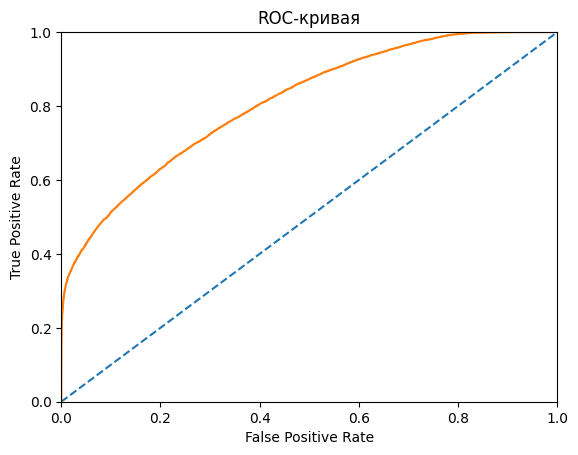

In [121]:
metrics(target_train, cat_model.predict(features_train), cat_model.predict_proba(features_train))

## Важность признаков

In [122]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,party_sobriety,14.807420
1,pcf_violation_category,14.390699
2,insurance_premium,12.510262
3,party_count,12.264960
4,primary_collision_factor,11.951170
5,motor_vehicle_involved_with,5.113239
6,vehicle_type,3.579161
7,vehicle_age,3.523558
8,collision_damage,2.953943
9,type_of_collision,2.677224


In [126]:
explainer = shap.TreeExplainer(cat_model)
shap_values=explainer.shap_values(Pool(features_train, target_train, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], features_train.iloc[3,:])

In [132]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[991, :], features_train.iloc[991, :])

In [128]:
features_train_small = features_train.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(explainer.expected_value, shap_small, features_train_small)

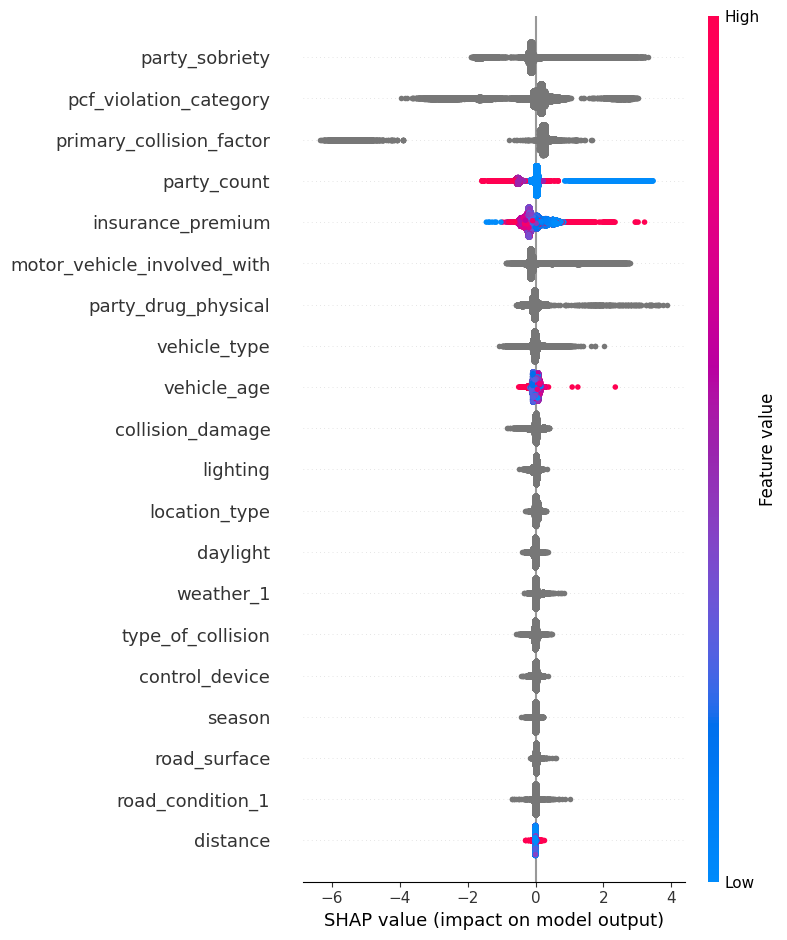

In [129]:
shap.summary_plot(shap_values, features_train)